# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [4]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from collections import Counter, defaultdict, OrderedDict
from ast import literal_eval
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import Imputer

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [5]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

In [6]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print('General population file', azdias.shape)
print('Feature summary file', feat_info.shape)


General population file (891221, 85)
Feature summary file (85, 4)


In [7]:
# get the first couple of rows of the population data set
pd.set_option('display.max_columns', None) # allow for head to show all column names
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,0.0,2,5,0.0,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,0.0,1,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,6,1957,1.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,8,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1,0.0,0.0,1,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,0.0,4.0,1.0,0.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,5,1963,5.0,0,3,32.0,10.0,10.0,5.0,3.0,2.0,1,8,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2,0.0,0.0,2,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [8]:
# get the first couple of rows of the feature summary data set
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [9]:
# check whether there are also any NAs in the dataset
print(azdias.isnull().sum().sum())

4896838


In [10]:
# data types of variables
data_type = Counter(feat_info['type'])

data_type

Counter({'categorical': 21,
         'ordinal': 49,
         'numeric': 7,
         'mixed': 7,
         'interval': 1})

In [11]:
# values for missing data
missing_vals = Counter(feat_info['missing_or_unknown'])
print(missing_vals)
mis_list = sorted([k for k, v in missing_vals.items()])
print(mis_list)


Counter({'[-1]': 26, '[-1,9]': 17, '[-1,0]': 16, '[0]': 12, '[]': 10, '[-1,0,9]': 1, '[-1,X]': 1, '[XX]': 1, '[-1,XX]': 1})
['[-1,0,9]', '[-1,0]', '[-1,9]', '[-1,XX]', '[-1,X]', '[-1]', '[0]', '[XX]', '[]']


In [12]:
# information level summary
info_level = Counter(feat_info['information_level'])
print(info_level)

Counter({'person': 43, 'macrocell_plz8': 8, 'household': 7, 'building': 7, 'microcell_rr3': 6, 'region_rr1': 5, 'microcell_rr4': 3, 'postcode': 3, 'community': 3})


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [13]:
# creating set with all possible missing values
all_mis_vals = set()

for item in mis_list:
    if item != '[]':
        new = item.replace('[', '').replace(']', '').split(',')
        all_mis_vals.update(new)
    else:
        all_mis_vals = list(all_mis_vals)
        all_mis_vals.append(item)
    
print(all_mis_vals)

['9', '-1', '0', 'X', 'XX', '[]']


In [14]:
#creating lists with all variable names grouped by missing value
missing_1 = [x for x, y in zip(feat_info['attribute'], feat_info['missing_or_unknown']) if '-1' in y]
missing_9 = [x for x, y in zip(feat_info['attribute'], feat_info['missing_or_unknown']) if '9' in y]
missing_X = [x for x, y in zip(feat_info['attribute'], feat_info['missing_or_unknown']) if 'X' in y]
missing_XX = [x for x, y in zip(feat_info['attribute'], feat_info['missing_or_unknown']) if 'XX' in y]
missing_0 = [x for x, y in zip(feat_info['attribute'], feat_info['missing_or_unknown']) if '0' in y]
missing_brack = [x for x, y in zip(feat_info['attribute'], feat_info['missing_or_unknown']) if '[]' in y]

missing_brack


['GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'ANZ_PERSONEN',
 'ANZ_TITEL',
 'ANZ_HH_TITEL',
 'KONSUMNAEHE',
 'GEBAEUDETYP_RASTER',
 'MOBI_REGIO',
 'ONLINE_AFFINITAET',
 'KBA13_ANZAHL_PKW']

In [15]:
# check data type of AGER_TYP variable
type(azdias['LP_FAMILIE_FEIN'][1])


numpy.float64

In [16]:
# Function to replace all missing values with numpy nan
def replace_miss(dataset, var, miss_val):
    dataset[var] = dataset[var].apply(lambda x: np.nan if str(x) == miss_val else x)


In [17]:
# Loop through all variables and replace missing values
for var in missing_1:
    replace_miss(azdias, var, '-1')

for var in missing_9:
    replace_miss(azdias, var, '9')

for var in missing_0:
    replace_miss(azdias, var, '0')
    # this needs to be added as there are some variables that are in float format
    replace_miss(azdias, var, '0.0')
    
for var in missing_X:
    replace_miss(azdias, var, 'X')

for var in missing_XX:
    replace_miss(azdias, var, 'XX')
    
for var in missing_brack:
    replace_miss(azdias, var, '[]')

In [18]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,4,NaN,10.0,0,NaN,15.0,4.0,2.0,2.0,1.0,1.0,NaN,NaN,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,1,1996.0,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3.0,1.0,NaN,2.0,5,NaN,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,1,1979.0,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2.0,0.0,NaN,1.0,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,NaN,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,6,1957.0,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1.0,0.0,NaN,1.0,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,5,1963.0,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2.0,0.0,NaN,2.0,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,NaN,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [19]:
print(azdias.isnull().sum().sum())

8373611


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

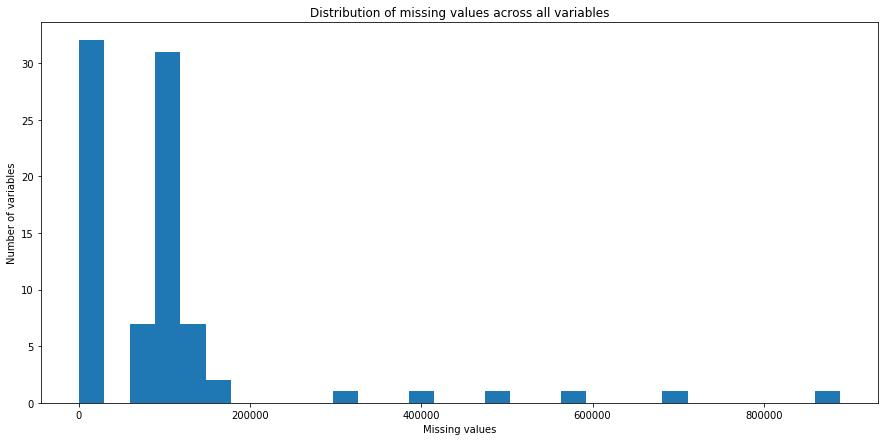

In [20]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

dist_nan = []
dict_col_nan = defaultdict()
for name in feat_info['attribute']:
    nans = azdias[name].isnull().sum()
    dist_nan.append(nans)
    dict_col_nan[name] = nans

plt.figure(figsize=(15, 7))
plt.xlabel('Missing values')
plt.ylabel('Number of variables')
plt.title('Distribution of missing values across all variables')
plt.hist(dist_nan, bins = 30);


In [21]:
# Investigate patterns in the amount of missing data in each column.
outliers = defaultdict(str)
for k, v in dict_col_nan.items():
    if v > 200000:
        row_index = feat_info.loc[feat_info['attribute'] == k].index[0]
        outliers[k] = feat_info['information_level'][row_index]
        
print(outliers)

defaultdict(<class 'str'>, {'AGER_TYP': 'person', 'GEBURTSJAHR': 'person', 'TITEL_KZ': 'person', 'ALTER_HH': 'household', 'KK_KUNDENTYP': 'household', 'KBA05_BAUMAX': 'microcell_rr3'})


In [22]:
# Check whether there are patterns in the amount of missing data based on the information level of each variable
all_levels = []
for k, v in info_level.items():
    all_levels.append(k)
    
all_levels

['person',
 'household',
 'building',
 'microcell_rr4',
 'microcell_rr3',
 'postcode',
 'region_rr1',
 'macrocell_plz8',
 'community']

In [23]:
# Create a dictionary that sorts the variables by information level
var_by_info = {}

for k, v in info_level.items():
    current_level = []
    for row in range(len(feat_info['attribute'])):
        if feat_info['information_level'][row] == k:
            current_level.append(feat_info['attribute'][row])
    var_by_info[k] = current_level
    
var_by_info

{'person': ['AGER_TYP',
  'ALTERSKATEGORIE_GROB',
  'ANREDE_KZ',
  'CJT_GESAMTTYP',
  'FINANZ_MINIMALIST',
  'FINANZ_SPARER',
  'FINANZ_VORSORGER',
  'FINANZ_ANLEGER',
  'FINANZ_UNAUFFAELLIGER',
  'FINANZ_HAUSBAUER',
  'FINANZTYP',
  'GEBURTSJAHR',
  'GFK_URLAUBERTYP',
  'GREEN_AVANTGARDE',
  'HEALTH_TYP',
  'LP_LEBENSPHASE_FEIN',
  'LP_LEBENSPHASE_GROB',
  'LP_FAMILIE_FEIN',
  'LP_FAMILIE_GROB',
  'LP_STATUS_FEIN',
  'LP_STATUS_GROB',
  'NATIONALITAET_KZ',
  'PRAEGENDE_JUGENDJAHRE',
  'RETOURTYP_BK_S',
  'SEMIO_SOZ',
  'SEMIO_FAM',
  'SEMIO_REL',
  'SEMIO_MAT',
  'SEMIO_VERT',
  'SEMIO_LUST',
  'SEMIO_ERL',
  'SEMIO_KULT',
  'SEMIO_RAT',
  'SEMIO_KRIT',
  'SEMIO_DOM',
  'SEMIO_KAEM',
  'SEMIO_PFLICHT',
  'SEMIO_TRADV',
  'SHOPPER_TYP',
  'SOHO_KZ',
  'TITEL_KZ',
  'VERS_TYP',
  'ZABEOTYP'],
 'household': ['ALTER_HH',
  'ANZ_PERSONEN',
  'ANZ_TITEL',
  'HH_EINKOMMEN_SCORE',
  'KK_KUNDENTYP',
  'W_KEIT_KIND_HH',
  'WOHNDAUER_2008'],
 'building': ['ANZ_HAUSHALTE_AKTIV',
  'ANZ_HH_TITEL',

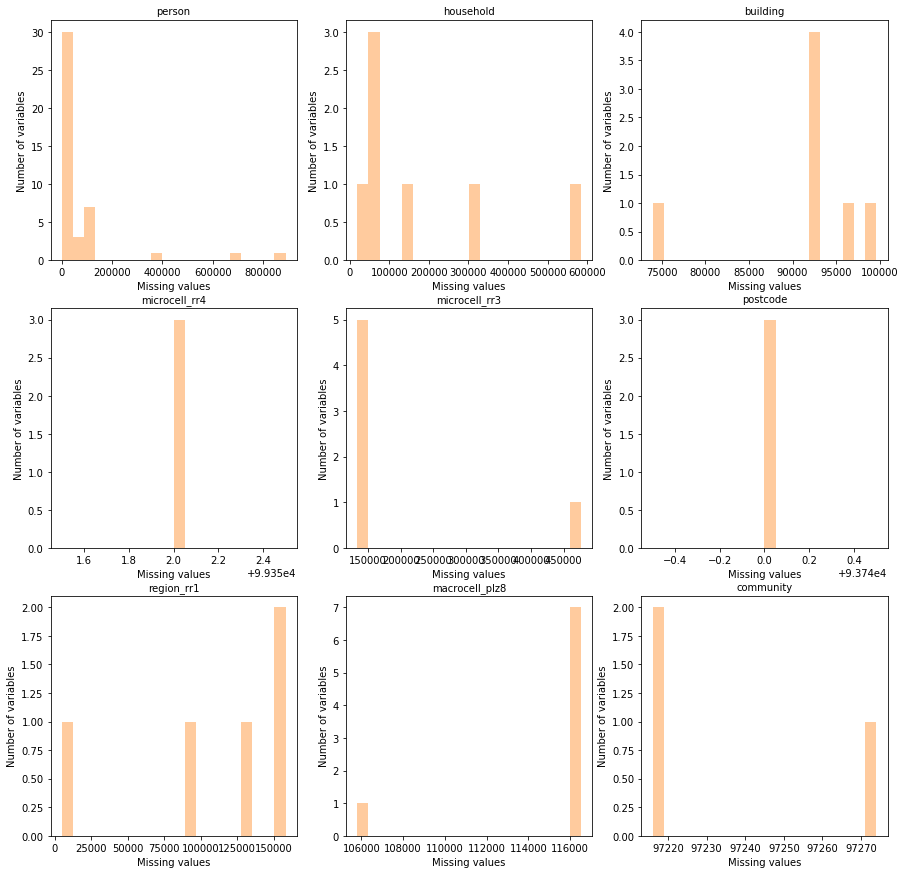

In [24]:
# plot the distributions of missing data per information level
total_list = []
for k, v in var_by_info.items():
    level_nan = []
    for var in v:
        nan = azdias[var].isnull().sum()
        level_nan.append(nan)
    total_list.append(level_nan)

# create subplots to display the distributions
fig, ax = plt.subplots(3, 3, figsize = [15, 15])
# level counter
counter = 0

for j in range(len(ax)):
    for i in range(len(ax[j])):
        if j == 2 and i == 3:
            break
        else:
            ax[j][i] = sb.distplot(total_list[counter], ax=ax[j][i], kde=False, bins=20, color=sb.color_palette()[1])
            ax[j][i].set_ylabel('Number of variables')
            ax[j][i].set_xlabel('Missing values')
            ax[j][i].set_title(all_levels[counter], fontsize=10)
            counter += 1
            

In [25]:
# Check whether there are patterns in the amount of missing data based on the data type of each variable
all_types = []
for k, v in data_type.items():
    all_types.append(k)
    
all_types


['categorical', 'ordinal', 'numeric', 'mixed', 'interval']

In [26]:
# Create a dictionary that sorts the variables by information level
var_by_type = {}

for k, v in data_type.items():
    current_type = []
    for row in range(len(feat_info['attribute'])):
        if feat_info['type'][row] == k:
            current_type.append(feat_info['attribute'][row])
    var_by_type[k] = current_type
    
var_by_type

{'categorical': ['AGER_TYP',
  'ANREDE_KZ',
  'CJT_GESAMTTYP',
  'FINANZTYP',
  'GFK_URLAUBERTYP',
  'GREEN_AVANTGARDE',
  'LP_FAMILIE_FEIN',
  'LP_FAMILIE_GROB',
  'LP_STATUS_FEIN',
  'LP_STATUS_GROB',
  'NATIONALITAET_KZ',
  'SHOPPER_TYP',
  'SOHO_KZ',
  'TITEL_KZ',
  'VERS_TYP',
  'ZABEOTYP',
  'KK_KUNDENTYP',
  'GEBAEUDETYP',
  'OST_WEST_KZ',
  'CAMEO_DEUG_2015',
  'CAMEO_DEU_2015'],
 'ordinal': ['ALTERSKATEGORIE_GROB',
  'FINANZ_MINIMALIST',
  'FINANZ_SPARER',
  'FINANZ_VORSORGER',
  'FINANZ_ANLEGER',
  'FINANZ_UNAUFFAELLIGER',
  'FINANZ_HAUSBAUER',
  'HEALTH_TYP',
  'RETOURTYP_BK_S',
  'SEMIO_SOZ',
  'SEMIO_FAM',
  'SEMIO_REL',
  'SEMIO_MAT',
  'SEMIO_VERT',
  'SEMIO_LUST',
  'SEMIO_ERL',
  'SEMIO_KULT',
  'SEMIO_RAT',
  'SEMIO_KRIT',
  'SEMIO_DOM',
  'SEMIO_KAEM',
  'SEMIO_PFLICHT',
  'SEMIO_TRADV',
  'HH_EINKOMMEN_SCORE',
  'W_KEIT_KIND_HH',
  'WOHNDAUER_2008',
  'KONSUMNAEHE',
  'KBA05_ANTG1',
  'KBA05_ANTG2',
  'KBA05_ANTG3',
  'KBA05_ANTG4',
  'KBA05_GBZ',
  'BALLRAUM',
  'E

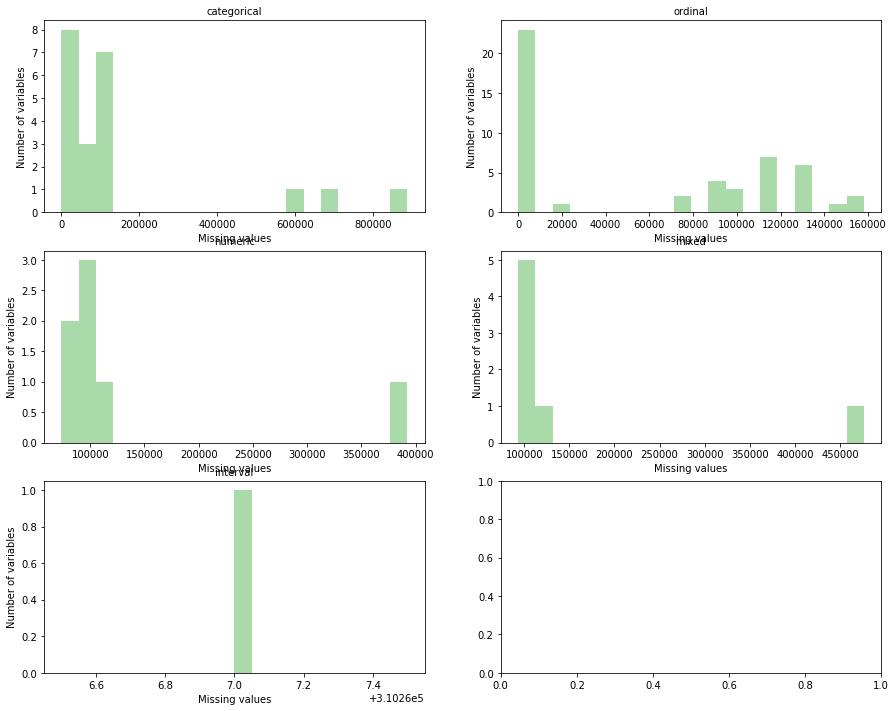

In [27]:
# plot the distributions of missing data per data type
total_types = []
for k, v in var_by_type.items():
    type_nan = []
    for var in v:
        nan = azdias[var].isnull().sum()
        type_nan.append(nan)
    total_types.append(type_nan)

# create subplots to display the distribution
fig, ax = plt.subplots(3, 2, figsize = [15, 12])
# level counter
counter = 0

for j in range(len(ax)):
    for i in range(len(ax[j])):
        if j == 2 and i == 1:
            break
        else:
            ax[j][i] = sb.distplot(total_types[counter], ax=ax[j][i], kde=False, bins = 20, color=sb.color_palette()[2])
            ax[j][i].set_ylabel('Number of variables')
            ax[j][i].set_xlabel('Missing values')
            ax[j][i].set_title(all_types[counter], fontsize=10)
            counter += 1



In [28]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

all_dropped = []
drop = ['AGER_TYP', 'GEBURTSJAHR', 'KK_KUNDENTYP', 'TITEL_KZ', 'ALTER_HH', 'KBA05_BAUMAX']
azdias.drop(drop, axis=1, inplace=True)
all_dropped.extend(drop)

azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,10.0,0,NaN,15.0,4.0,2.0,2.0,1.0,1.0,NaN,NaN,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3.0,1.0,2.0,5,2.0,0.0,6.0,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2.0,0.0,1.0,5,1.0,0.0,4.0,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1.0,0.0,1.0,3,0.0,0.0,1.0,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2.0,0.0,2.0,4,4.0,0.0,5.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [29]:
outliers


defaultdict(str,
            {'AGER_TYP': 'person',
             'GEBURTSJAHR': 'person',
             'TITEL_KZ': 'person',
             'ALTER_HH': 'household',
             'KK_KUNDENTYP': 'household',
             'KBA05_BAUMAX': 'microcell_rr3'})

#### Discussion 1.1.2: Assess Missing Data in Each Column

The biggest outlier variables with the most missing values were the variables AGER_TYP, GEBURTSJAHR, KK_KUNDENTYP, TITEL_KZ, ALTER_HH, KBA05_BAUMAX. The former three are person level variables and the latter are household and microcell_rr3 level variables, respectively.

Looking at the distributions of the missing values grouped by information level and by data type, the same six outliers stand out. Microcell_rr4, postcode, community, and macrocell_plz8 have roughly the same amount of missing values for all variables. The big outliers from the person, household and microcell_rr3 levels will be removed, as mentioned above (AGER_TYP, GEBURTSJAHR, KK_KUNDENTYP, TITEL_KZ, ALTER_HH, KBA05_BAUMAX).

The six removed outliers were also visible in the categorical and numeric data type categories and respective plots. For the mixed and ordinal data types, there are also come outliers, however, in the overall distribution of the dataset these do not stand out, so I will leave them in for now.


#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

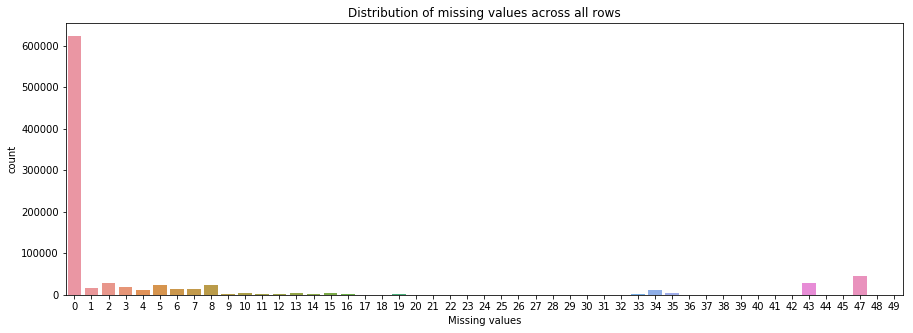

In [30]:
# Count the missing values per row
mis_val_rows = azdias.isnull().sum(axis=1)

# Add the missing values as a column in the dataframe
azdias['missing_per_row'] = mis_val_rows

# Plot the distribution of missing values across a row
plt.figure(figsize=(15, 5))
plt.xlabel('Missing values')
plt.ylabel('Number of variables')
plt.title('Distribution of missing values across all rows')
sb.countplot(mis_val_rows);


In [31]:
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,missing_per_row
0,2.0,1,2.0,3,4,3,5,5,3,4,10.0,0,NaN,15.0,4.0,2.0,2.0,1.0,1.0,NaN,NaN,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43
1,1.0,2,5.0,1,5,2,5,4,5,1,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3.0,1.0,2.0,5,2.0,0.0,6.0,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0
2,3.0,2,3.0,1,4,1,2,3,5,1,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2.0,0.0,1.0,5,1.0,0.0,4.0,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0
3,4.0,2,2.0,4,2,5,2,1,2,6,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1.0,0.0,1.0,3,0.0,0.0,1.0,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,7
4,3.0,1,5.0,4,3,4,1,3,2,5,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2.0,0.0,2.0,4,4.0,0.0,5.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,0


In [32]:
# Group by number of missing rows and get count and statistics
azdias_group = azdias.groupby('missing_per_row')

azdias_group.describe().head()

ALTERSKATEGORIE_GROB                                          \
                               count      mean       std  min  25%  50%  75%   
missing_per_row                                                                
0                           623277.0  2.792530  1.026484  1.0  2.0  3.0  4.0   
1                            15740.0  3.131576  1.151316  1.0  2.0  4.0  4.0   
2                            27862.0  2.792405  1.085936  1.0  2.0  3.0  4.0   
3                            17629.0  2.804754  0.905194  1.0  2.0  3.0  3.0   
4                            11188.0  2.243207  0.883347  1.0  1.0  3.0  3.0   

                     ANREDE_KZ                                               \
                 max     count      mean       std  min  25%  50%  75%  max   
missing_per_row                                                               
0                4.0  623277.0  1.511211  0.499875  1.0  1.0  2.0  2.0  2.0   
1                4.0   15740.0  1.555083  0.496972  1.0  1.0  2.0  2.0  2.0   
2                4.0   27862.0  1.526021  0.499331  1.0  1.0  2.0  2.0  2.0   
3                4.0   17629.0  1.496341  0.500001  1.0  1.0  1.0  2.0  2.0   
4                4.0   12605.0  1.675526  0.468197  1.0  1.0  2.0  2.0  2.0   

                ANZ_HAUSHALTE_AKTIV                                       \
                              count       mean        std  min  25%  50%   
missing_per_row                                                            
0                          623277.0   8.440680  15.391686  1.0  2.0  4.0   
1                           14041.0  14.711559  21.773994  1.0  3.0  8.0   
2                           27749.0   4.513856   8.635270  1.0  1.0  2.0   
3                           16980.0   6.631037  13.545454  1.0  2.0  3.0   
4                           12487.0  10.976055  19.059510  1.0  2.0  6.0   

                             ANZ_HH_TITEL                                     \
                  75%    max        count      mean       std  min  25%  50%   
missing_per_row                                                                
0                10.0  536.0     623277.0  0.039778  0.307025  0.0  0.0  0.0   
1                17.0  379.0      15740.0  0.078018  0.433389  0.0  0.0  0.0   
2                 5.0  353.0      27862.0  0.021930  0.243917  0.0  0.0  0.0   
3                 8.0  353.0      17072.0  0.036258  0.411207  0.0  0.0  0.0   
4                12.0  445.0      12599.0  0.043972  0.267229  0.0  0.0  0.0   

                           ANZ_PERSONEN                                     \
                 75%   max        count      mean       std  min  25%  50%   
missing_per_row                                                              
0                0.0  20.0     623277.0  1.808252  1.123964  1.0  1.0  1.0   
1                0.0  18.0      15740.0  0.861626  0.908013  0.0  0.0  1.0   
2                0.0  13.0      27862.0  2.262257  1.244905  0.0  1.0  2.0   
3                0.0  17.0      17629.0  1.395541  0.905662  0.0  1.0  1.0   
4                0.0  12.0      12605.0  1.847045  1.210118  0.0  1.0  1.0   

                           ANZ_TITEL                                          \
                 75%   max     count      mean       std  min  25%  50%  75%   
missing_per_row                                                                
0                2.0  38.0  623277.0  0.004149  0.068321  0.0  0.0  0.0  0.0   
1                1.0  45.0   15740.0  0.003494  0.062157  0.0  0.0  0.0  0.0   
2                3.0  13.0   27862.0  0.004702  0.072485  0.0  0.0  0.0  0.0   
3                2.0   9.0   17629.0  0.003460  0.063370  0.0  0.0  0.0  0.0   
4                2.0  15.0   12605.0  0.004046  0.067127  0.0  0.0  0.0  0.0   

                        ARBEIT                                               \
                 max     count      mean       std  min  25%  50%  75%  max   
missing_per_row                                                     

In [33]:
# Write code to divide the data into two subsets based on the number of missing values in each row.
azdias_0 = azdias[azdias['missing_per_row'] < 20]

azdias_missing = azdias[azdias['missing_per_row'] >= 20]

In [34]:
# Resetting the index of azdias_0
azdias_0.reset_index(inplace=True)
azdias_0.drop('index', axis=1, inplace=True)

# Printing the number of rows of the new dataframes
print(azdias_0.shape)

print(azdias_missing.shape)


(797078, 80)
(94143, 80)


/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [35]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
print(dict_col_nan)

# choosing 5 columns from this list of variables that have no or very little missing data
# FINANZTYP
# SEMIO_VERT
# GREEN_AVANTGARDE
# ZABEOTYP
# ONLINE_AFFINITAET
# FINANZ_MINIMALIST
# FINANZ_SPARER
# SEMIO_KULT


defaultdict(None, {'AGER_TYP': 685843, 'ALTERSKATEGORIE_GROB': 2881, 'ANREDE_KZ': 0, 'CJT_GESAMTTYP': 4854, 'FINANZ_MINIMALIST': 0, 'FINANZ_SPARER': 0, 'FINANZ_VORSORGER': 0, 'FINANZ_ANLEGER': 0, 'FINANZ_UNAUFFAELLIGER': 0, 'FINANZ_HAUSBAUER': 0, 'FINANZTYP': 0, 'GEBURTSJAHR': 392318, 'GFK_URLAUBERTYP': 4854, 'GREEN_AVANTGARDE': 0, 'HEALTH_TYP': 111196, 'LP_LEBENSPHASE_FEIN': 97632, 'LP_LEBENSPHASE_GROB': 94572, 'LP_FAMILIE_FEIN': 77792, 'LP_FAMILIE_GROB': 77792, 'LP_STATUS_FEIN': 4854, 'LP_STATUS_GROB': 4854, 'NATIONALITAET_KZ': 108315, 'PRAEGENDE_JUGENDJAHRE': 108164, 'RETOURTYP_BK_S': 4854, 'SEMIO_SOZ': 0, 'SEMIO_FAM': 0, 'SEMIO_REL': 0, 'SEMIO_MAT': 0, 'SEMIO_VERT': 0, 'SEMIO_LUST': 0, 'SEMIO_ERL': 0, 'SEMIO_KULT': 0, 'SEMIO_RAT': 0, 'SEMIO_KRIT': 0, 'SEMIO_DOM': 0, 'SEMIO_KAEM': 0, 'SEMIO_PFLICHT': 0, 'SEMIO_TRADV': 0, 'SHOPPER_TYP': 111196, 'SOHO_KZ': 73499, 'TITEL_KZ': 889061, 'VERS_TYP': 111196, 'ZABEOTYP': 0, 'ALTER_HH': 310267, 'ANZ_PERSONEN': 73499, 'ANZ_TITEL': 73499, 'HH_E

In [36]:
print(azdias_0['SEMIO_VERT'].describe())

print(azdias_missing['SEMIO_VERT'].describe())

count    797078.00000
mean          4.27745
std           1.94482
min           1.00000
25%           2.00000
50%           5.00000
75%           6.00000
max           7.00000
Name: SEMIO_VERT, dtype: float64
count    94143.000000
mean         1.875370
std          1.919307
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          7.000000
Name: SEMIO_VERT, dtype: float64


In [37]:
# Function to plot the two different datasets on the same column
def col_comp(dataset1, dataset2, col):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    sb.countplot(dataset1[col], color=sb.color_palette()[1])
    plt.xlabel('Possible returns')
    plt.ylabel('Number of occurences')
    plt.title(col+' in full dataset')
    
    plt.subplot(1, 2, 2)
    sb.countplot(dataset2[col], color=sb.color_palette()[2])
    plt.xlabel('Possible returns')
    plt.ylabel('Number of occurences')
    plt.title(col+' in missing values dataset')

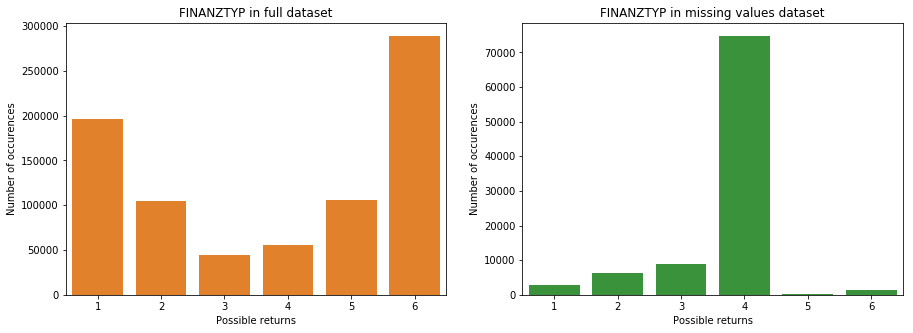

In [38]:
# FINANZTYP
col_comp(azdias_0, azdias_missing, 'FINANZTYP')

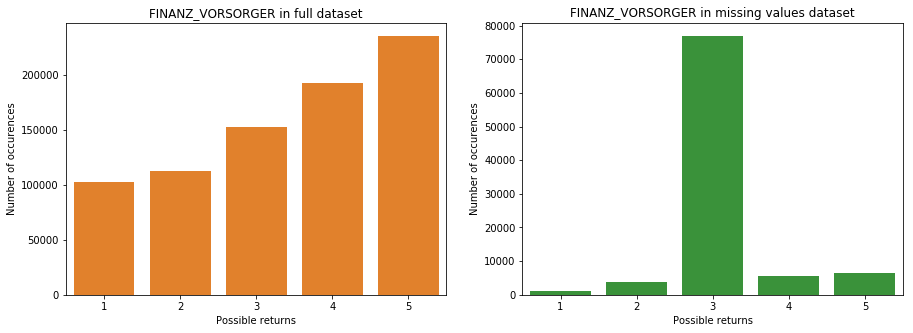

In [39]:
# SEMIO_VERT
col_comp(azdias_0, azdias_missing, 'FINANZ_VORSORGER')

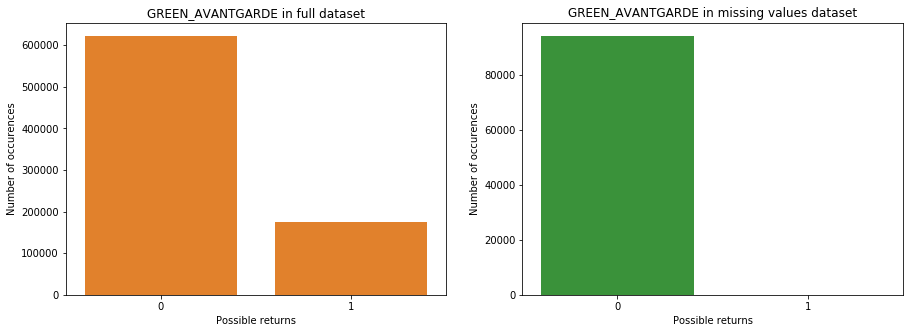

In [40]:
# GREEN_AVANTGARDE
col_comp(azdias_0, azdias_missing, 'GREEN_AVANTGARDE')

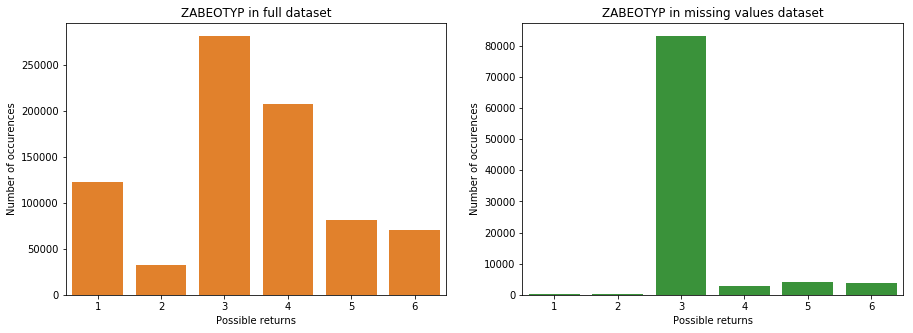

In [41]:
# ZABEOTYP
col_comp(azdias_0, azdias_missing, 'ZABEOTYP')

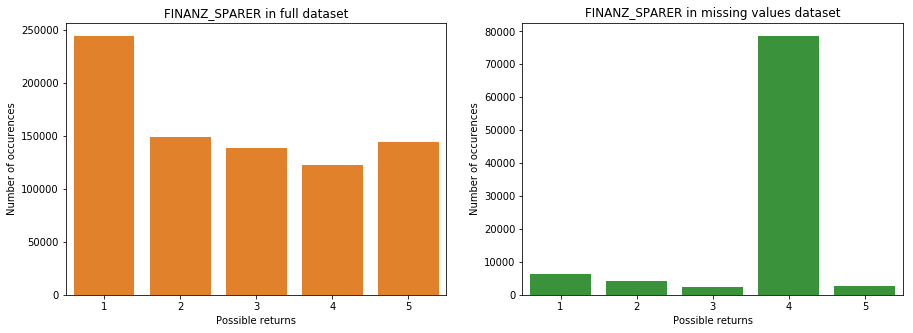

In [42]:
# FINANZ_SPARER
col_comp(azdias_0, azdias_missing, 'FINANZ_SPARER')

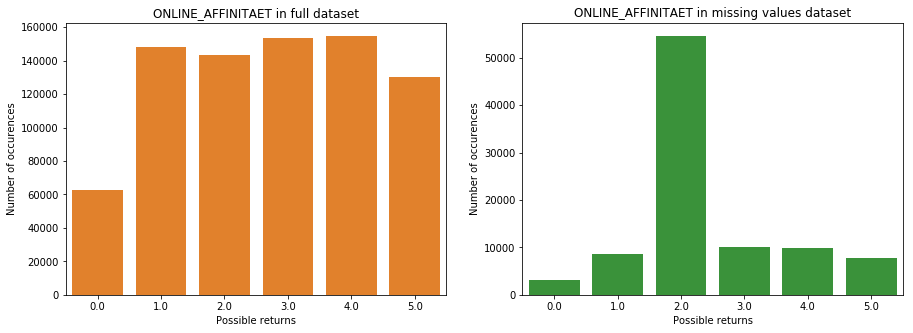

In [43]:
# ONLINE_AFFINITAET
col_comp(azdias_0, azdias_missing, 'ONLINE_AFFINITAET')

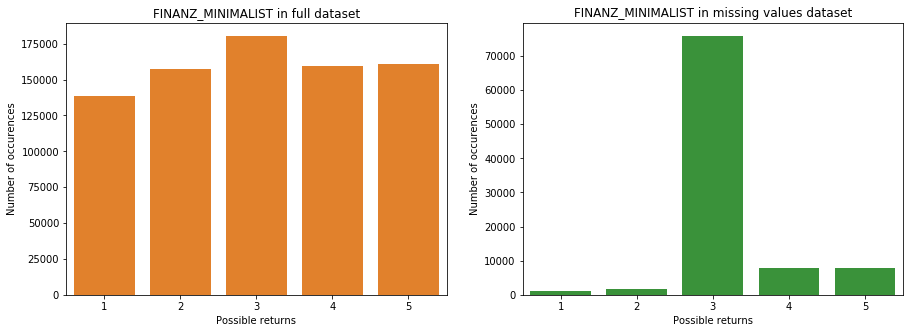

In [44]:
# FINANZ_MINIMALIST
col_comp(azdias_0, azdias_missing, 'FINANZ_MINIMALIST')

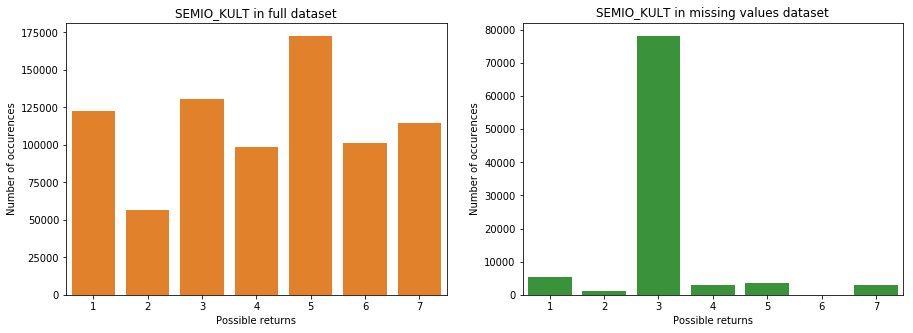

In [45]:
# SEMIO_KULT
col_comp(azdias_0, azdias_missing, 'SEMIO_KULT')

#### Discussion 1.1.3: Assess Missing Data in Each Row

Based on the above variables that I chose (which have no or very few missing values), the data set containing no missing values is seemingly different from the data set containing 1 or more missing value per data point.

This means that simply dropping the rows that have missing data may not be statistically insignificant and could have effects on the overall algorithm later on.

The only variable that seems to be similar in both data sets is GREEN_AVANTGARDE and this variable is missing values in 4854 rows.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [46]:
# How many features are there of each data type?
data_type


Counter({'categorical': 21,
         'ordinal': 49,
         'numeric': 7,
         'mixed': 7,
         'interval': 1})

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [47]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
cat_var = [x for x, y in zip(feat_info['attribute'], feat_info['type']) if 'categorical' in y]
cat_var.remove('AGER_TYP')
cat_var.remove('KK_KUNDENTYP')
cat_var.remove('TITEL_KZ')
cat_var

['ANREDE_KZ',
 'CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'SOHO_KZ',
 'VERS_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'OST_WEST_KZ',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [48]:
azdias_0[cat_var].describe()

,ANREDE_KZ,CJT_GESAMTTYP,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,GEBAEUDETYP
count,797078.000000,792446.000000,797078.000000,792446.000000,797078.000000,766096.000000,766096.000000,792446.000000,792446.000000,763513.000000,760740.000000,797078.000000,760740.000000,797078.000000,797078.000000
mean,1.521377,3.502617,3.799343,7.470816,0.219721,3.911696,2.377403,4.790036,2.459855,1.168555,1.578349,0.008414,1.518069,3.379051,2.799818
std,0.499543,1.537408,2.084766,3.574601,0.414058,3.936601,1.699496,3.520678,1.511788,0.474736,1.026083,0.091344,0.499674,1.407836,2.657594
min,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,1.000000,2.000000,2.000000,4.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,3.000000,1.000000
50%,2.000000,4.000000,4.000000,8.000000,0.000000,1.000000,1.000000,4.000000,2.000000,1.000000,2.000000,0.000000,2.000000,3.000000,1.000000
75%,2.000000,5.000000,6.000000,11.000000,0.000000,8.000000,4.000000,9.000000,4.000000,1.000000,2.000000,0.000000,2.000000,4.000000,3.000000
max,2.000000,6.000000,6.000000,12.000000,1.000000,11.000000,5.000000,10.000000,5.000000,3.000000,3.000000,1.000000,2.000000,6.000000,8.000000


In [49]:
# three categorical variables not plotted in the above descriptive overview
three = ['OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
print(azdias_0[three].describe())

print('OST_WEST_KZ', azdias_0['OST_WEST_KZ'].unique())
print('CAMEO_DEUG_2015', azdias_0['CAMEO_DEUG_2015'].unique())
print('CAMEO_DEU_2015', azdias_0['CAMEO_DEU_2015'].unique())

       OST_WEST_KZ CAMEO_DEUG_2015 CAMEO_DEU_2015
count       797078          791210         791210
unique           2               9             44
top              W               8             6B
freq        628696          134394          56642
OST_WEST_KZ ['W' 'O']
CAMEO_DEUG_2015 ['8' '4' '2' '6' '1' '9' '5' '7' nan '3']
CAMEO_DEU_2015 ['8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D' '9E'
 nan '9B' '1B' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C' '9C'
 '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F' '5F' '1C']


In [50]:
# Check whether there are any missing values in the OST_WEST_KZ column
# Get the most frequent return for OST_WEST_KZ
freq_ost = azdias_0['OST_WEST_KZ'].value_counts()
print(freq_ost)
print(azdias_0['OST_WEST_KZ'].isnull().sum())

W    628696
O    168382
Name: OST_WEST_KZ, dtype: int64
0


In [51]:
# Re-encode categorical variable(s) to be kept in the analysis.
encode_ow = pd.get_dummies(azdias_0['OST_WEST_KZ'], prefix='OST_WEST_KZ')

pd.concat([azdias_0, encode_ow], axis=1)

azdias_0.drop('OST_WEST_KZ', axis=1, inplace=True)
cat_var.remove('OST_WEST_KZ')


/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [52]:
# Keeping overview list with all dropped variables up to date
all_dropped.append('OST_WEST_KZ')

In [53]:
# Create list with all multi-level categorical variables
multi_cat = [x for x in cat_var if len(azdias_0[x].unique()) > 2]

multi_cat

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'VERS_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [54]:
# Dropping the rough scales of variables that have both rough and fine scales in multi-level categorical variables
rough = ['LP_FAMILIE_GROB', 'LP_STATUS_GROB', 'CAMEO_DEUG_2015']
azdias_0.drop(rough, axis=1, inplace=True)

multi_cat.remove('LP_FAMILIE_GROB')
multi_cat.remove('LP_STATUS_GROB')
multi_cat.remove('CAMEO_DEUG_2015')


/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [55]:
# Keeping overview list with all dropped variables up to date
all_dropped.extend(['LP_FAMILIE_GROB', 'LP_STATUS_GROB', 'CAMEO_DEUG_2015'])


In [56]:
# Remaining multi-categorical variables
multi_cat


['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_STATUS_FEIN',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'VERS_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEU_2015']

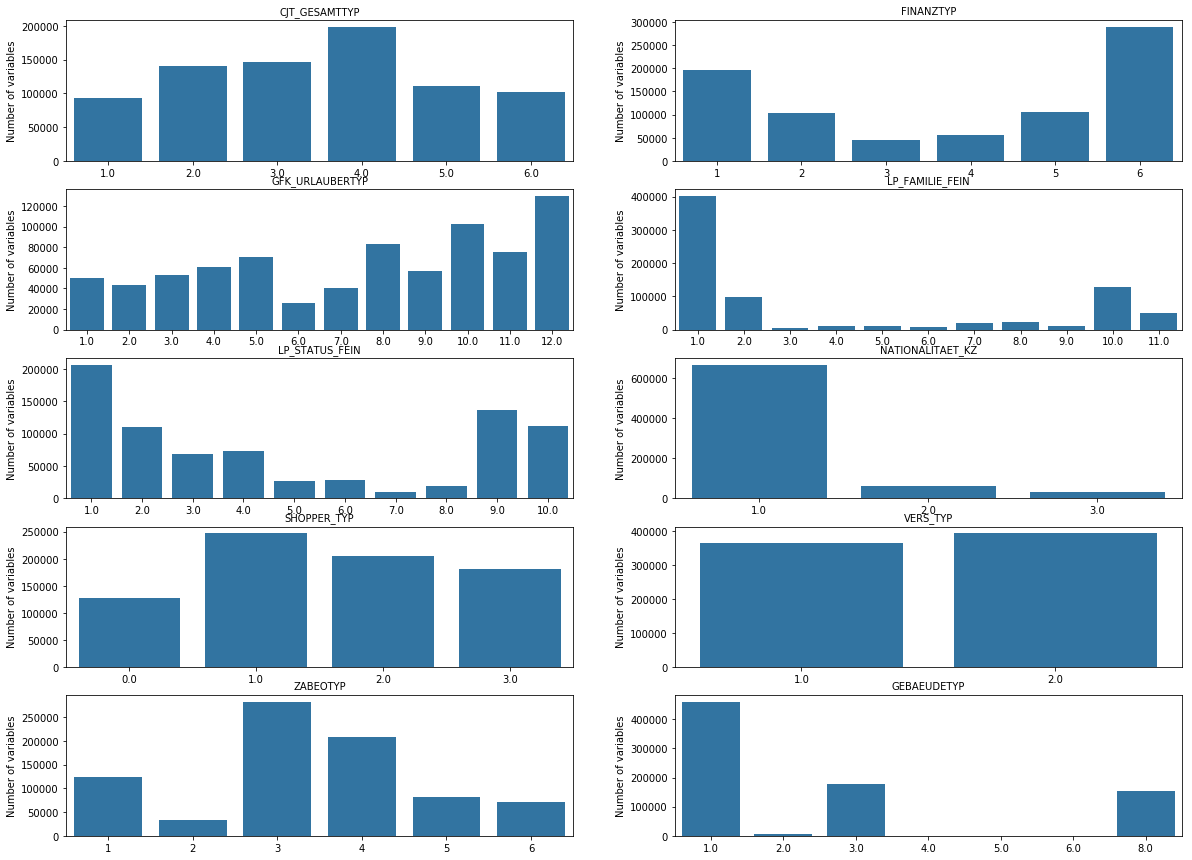

In [57]:
# create subplots for countplots to see distributions
fig, ax = plt.subplots(5, 2, figsize = [20, 15])
# level counter
counter = 0

for j in range(len(ax)):
    for i in range(len(ax[j])):
        if j == 4 and i == 2:
            break
        else:
            ax[j][i] = sb.countplot(azdias_0[multi_cat[counter]], ax=ax[j][i], color=sb.color_palette()[0])
            ax[j][i].set_ylabel('Number of variables')
            ax[j][i].set_xlabel('')
            ax[j][i].set_title(multi_cat[counter], fontsize=10)
            counter += 1
            

In [58]:
# Function to impute categorical variables with their mode
def fillna_cat(dataset, var):
    count_var = dataset[var].value_counts()
    mode_var = count_var[:1].index[0]
    dataset[var].fillna(mode_var, inplace=True)
    missing = dataset[var].isnull().sum().sum()
    return dataset


In [59]:
# Fill all NaNs with the mode of CAMEO_DEU_2015
fillna_cat(azdias_0, 'CAMEO_DEU_2015')
multi_cat.remove('CAMEO_DEU_2015')

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [60]:
# Imputing all NaNs from the multi-categorical variables (except CAMEO_DEU_2015)
imp = Imputer(missing_values='NaN', strategy='most_frequent', axis=0)
imp.fit(azdias_0[multi_cat])
impute_multi = pd.DataFrame(imp.transform(azdias_0[multi_cat]), columns=azdias_0[multi_cat].columns)


In [61]:
# Check whether imputation worked
impute_multi[multi_cat].isnull().sum().sum()


0

In [62]:
# Combine all multi_cat variables with CAMEO_DEU_2015 and create a placeholder dataframe
place_holder = pd.concat([impute_multi, azdias_0['CAMEO_DEU_2015']], axis=1)
# Add CAMEO_DEU_2015 to the multi_cat variable again
multi_cat.append('CAMEO_DEU_2015')


In [63]:
# Using label encoder and Onehotencoding to create dummy variables for the remaining multi categoricals
# Label encoder, in particular for the variable CAMEO_DEU_2015
labelen = preprocessing.LabelEncoder()
new_labels = place_holder.apply(labelen.fit_transform)


In [64]:
# Onehotencoding function
def onehot(dataset, column):
    '''
    Applies OneHotEncoder on specified column in dataframe
    Inputs: dataset and column/header name
    Outputs: encoded variables in dataframe form
    '''
    dummies = preprocessing.OneHotEncoder()    
    onehotlabels = dummies.fit_transform(dataset[column].values.reshape(-1, 1)).toarray()
    
    # turning this back into a dataframe
    columns = [column+'_'+str(x) for x in range(len(dataset[column].unique())) ]
    dfonehot = pd.DataFrame(onehotlabels, columns=columns)    
    return dfonehot


In [65]:
# Onehotencoding all variables in 
azdias_clean = azdias_0

for cat in multi_cat:
    enc = onehot(new_labels, cat)
    azdias_clean = pd.concat([azdias_clean, enc], axis=1)


In [66]:
# Remove the original variables that were encoded
azdias_clean.drop(multi_cat, axis=1, inplace=True)


In [67]:
# Check the shape of the new dataframe and whether there are any missing values
print(azdias_clean.shape)
print(azdias_clean.isnull().sum().sum())


(797078, 176)
793716


In [68]:
# Keeping overview list with all dropped variables up to date
all_dropped.extend(multi_cat)
all_dropped.append('CAMEO_DEU_2015')


#### Discussion 1.2.1: Re-Encode Categorical Features

I have one-hot-encoded the binary variable OST_WEST_KZ as this categorical variable was previously encoded with 'O' and 'W'. From the remaining categorical variables, I filtered out the ones that have three or more categories. I looked at those and decided to drop 'LP_FAMILIE_GROB', 'LP_STATUS_GROB', 'CAMEO_DEUG_2015' because these were rough scales of the same variables with finer scales. So there is no information that got lost by dropping these. Out of the remaining 10 multi-categorical variables, I decided to one-hot-encode these and keep them for now. Looking at the countplots of those 10, none of them had similar distributions.

For the encoding, I used Label Encoder and OneHotEncoder. Label Encoder was mainly important for the variable 'CAMEO_DEU_2015' as this variable was alphanumeric and not just numeric. I created a function that takes the dataset and the column name and then encodes the variable and assigns it new column names. I then merged the newly created columns with the existing dataframe. 


#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [69]:
# List of all mixed variables
mix_var = [x for x, y in zip(feat_info['attribute'], feat_info['type']) if 'mixed' in y]

mix_var

['LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'KBA05_BAUMAX',
 'PLZ8_BAUMAX']

In [70]:
# Remove the variable KBA05_BAUMAX from the summary list mix_var
mix_var.remove('KBA05_BAUMAX')


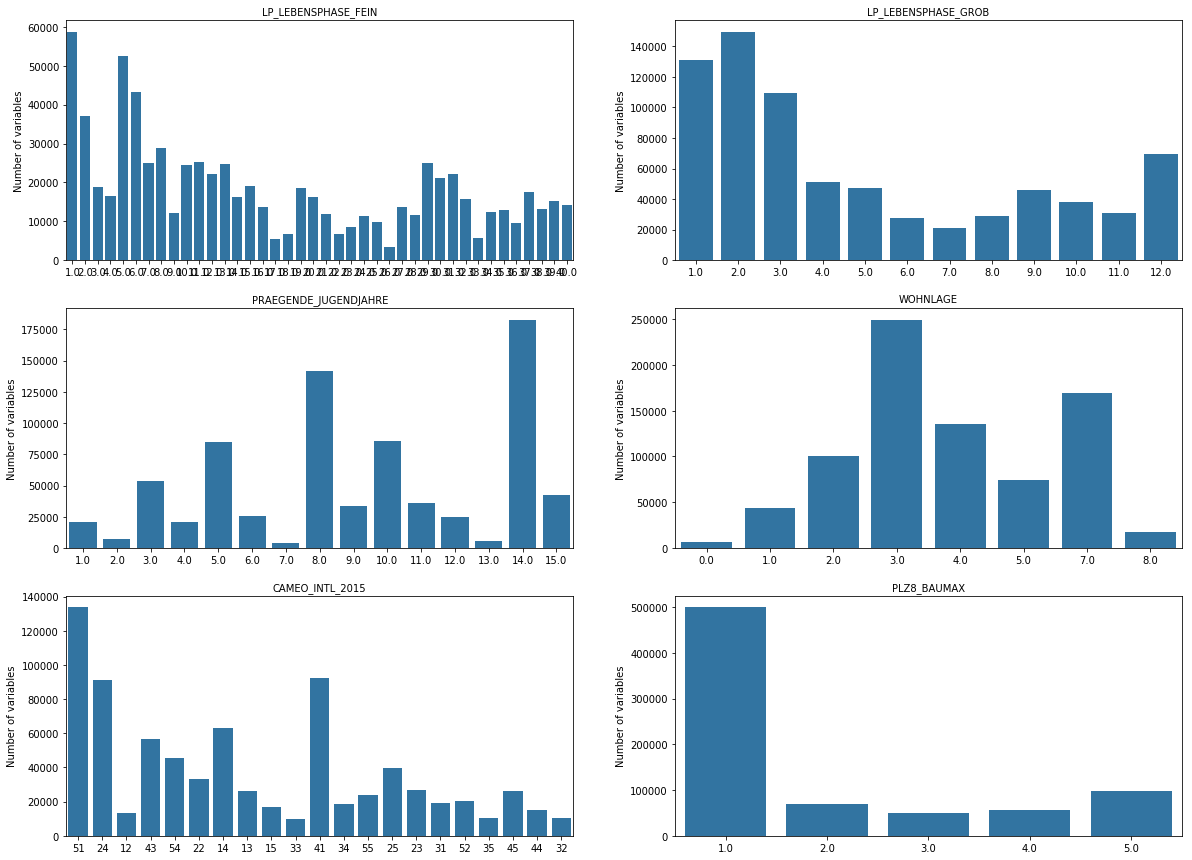

In [71]:
# create subplots for countplots to see distributions
fig, ax = plt.subplots(3, 2, figsize = [20, 15])
# level counter
counter = 0

for j in range(len(ax)):
    for i in range(len(ax[j])):
        if j == 2 and i == 2:
            break
        else:
            ax[j][i] = sb.countplot(azdias_0[mix_var[counter]], ax=ax[j][i], color=sb.color_palette()[0])
            ax[j][i].set_ylabel('Number of variables')
            ax[j][i].set_xlabel('')
            ax[j][i].set_title(mix_var[counter], fontsize=10)
            counter += 1
            

In [72]:
# Remove the variable LP_LEBENSPHASE_GROB from the summary list mix_var as well as the dataframe as this has
# the same distribution as the LP_LEBENSPHASE_FEIN
mix_var.remove('LP_LEBENSPHASE_GROB')
azdias_clean.drop('LP_LEBENSPHASE_GROB', axis=1, inplace=True)

# Keeping overview list with all dropped variables up to date
all_dropped.append('LP_LEBENSPHASE_GROB')


In [73]:
# Imputing all NaNs from the mixed-type variables
imp = Imputer(missing_values='NaN', strategy='most_frequent', axis=0)
imp.fit(azdias_clean[mix_var])
impute_multi = pd.DataFrame(imp.transform(azdias_clean[mix_var]), columns=azdias_clean[mix_var].columns)

# Replace the old columns with the newly imputed ones
azdias_clean.drop(mix_var, axis=1, inplace=True)
azdias_clean = pd.concat([azdias_clean, impute_multi], axis=1)

In [74]:
# Check whether imputing worked
azdias_clean[mix_var].isnull().sum().sum()


0

In [75]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
mapping_jugend = {1: '40s - war years (Mainstream, E+W)', 
                  2: '40s - reconstruction years (Avantgarde, E+W)',
                  3: '50s - economic miracle (Mainstream, E+W)',
                  4: '50s - milk bar / Individualisation (Avantgarde, E+W)',
                  5: '60s - economic miracle (Mainstream, E+W)',
                  6: '60s - generation 68 / student protestors (Avantgarde, W)',
                  7: '60s - opponents to the building of the Wall (Avantgarde, E)',
                  8: '70s - family orientation (Mainstream, E+W)',
                  9: '70s - peace movement (Avantgarde, E+W)',
                  10: '80s - Generation Golf (Mainstream, W)',
                  11: '80s - ecological awareness (Avantgarde, W)',
                  12: '80s - FDJ / communist party youth organisation (Mainstream, E)',
                  13: '80s - Swords into ploughshares (Avantgarde, E)',
                  14: '90s - digital media kids (Mainstream, E+W)',
                  15: '90s - ecological awareness (Avantgarde, E+W)'}

mapping_jugend

{1: '40s - war years (Mainstream, E+W)',
 2: '40s - reconstruction years (Avantgarde, E+W)',
 3: '50s - economic miracle (Mainstream, E+W)',
 4: '50s - milk bar / Individualisation (Avantgarde, E+W)',
 5: '60s - economic miracle (Mainstream, E+W)',
 6: '60s - generation 68 / student protestors (Avantgarde, W)',
 7: '60s - opponents to the building of the Wall (Avantgarde, E)',
 8: '70s - family orientation (Mainstream, E+W)',
 9: '70s - peace movement (Avantgarde, E+W)',
 10: '80s - Generation Golf (Mainstream, W)',
 11: '80s - ecological awareness (Avantgarde, W)',
 12: '80s - FDJ / communist party youth organisation (Mainstream, E)',
 13: '80s - Swords into ploughshares (Avantgarde, E)',
 14: '90s - digital media kids (Mainstream, E+W)',
 15: '90s - ecological awareness (Avantgarde, E+W)'}

In [76]:
# Binary categorical variable for movemoment
movement_main = [k for (k, v) in mapping_jugend.items() if 'Mainstream' in str(v)]
movement_avant = [k for (k, v) in mapping_jugend.items() if 'Avantgarde' in str(v)]

movement = {0: movement_main, 1: movement_avant}

print(movement)

{0: [1, 3, 5, 8, 10, 12, 14], 1: [2, 4, 6, 7, 9, 11, 13, 15]}


In [77]:
# Add the new movement variable to the dataframe
azdias_clean['MOVEMENT'] = azdias_clean['PRAEGENDE_JUGENDJAHRE'].map(lambda x: 0 if x in movement[0] else 1)

azdias_clean['MOVEMENT'].head()


0    0
1    1
2    0
3    0
4    0
Name: MOVEMENT, dtype: int64

In [78]:
# Interval variable for decades
decades = ['40', '50', '60', '70', '80', '90']

def split_dec(decades):
    all_decades = defaultdict()
    for i in decades:
        decade_x = [k for (k, v) in mapping_jugend.items() if i in str(v)]
        all_decades[int(i)] = decade_x
        
    return all_decades

decades_dict = split_dec(decades)

decades_dict


defaultdict(None,
            {40: [1, 2],
             50: [3, 4],
             60: [5, 6, 7],
             70: [8, 9],
             80: [10, 11, 12, 13],
             90: [14, 15]})

In [79]:
# Add the new decade variable to the dataframe
azdias_clean['PRAEGENDE_JUGENDJAHRE'] = azdias_clean['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: int(x))
azdias_clean['DECADE'] = azdias_clean['PRAEGENDE_JUGENDJAHRE'].map(lambda x: 40 if x in decades_dict[40] else (50 if x in decades_dict[50] else (60 if x in decades_dict[60] else (70 if x in decades_dict[70] else (80 if x in decades_dict[80] else 90)))))

azdias_clean['DECADE'].head()

0    90
1    90
2    70
3    70
4    50
Name: DECADE, dtype: int64

In [80]:
# Remove PRAEGENDE_JUGENDJAHRE from the dataframe
azdias_clean.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)

print(azdias_clean.shape)

# Remove PRAEGENDE_JUGENDJAHRE from the summary mix_var list
mix_var.remove('PRAEGENDE_JUGENDJAHRE')
print(mix_var)

# Keeping overview list with all dropped variables up to date
all_dropped.append('PRAEGENDE_JUGENDJAHRE')


(797078, 176)
['LP_LEBENSPHASE_FEIN', 'WOHNLAGE', 'CAMEO_INTL_2015', 'PLZ8_BAUMAX']


In [81]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias_clean['CAMEO_INTL_2015'] = azdias_clean['CAMEO_INTL_2015'].apply(lambda x: str(x))
azdias_clean['WEALTH'] = azdias_clean['CAMEO_INTL_2015'].map(lambda x: x[:1])
azdias_clean['LIFE_STAGE'] = azdias_clean['CAMEO_INTL_2015'].map(lambda x: x[1:2])

# Removing CAMEO_INTL_2015 from the dataframe
azdias_clean.drop('CAMEO_INTL_2015', axis=1, inplace=True)
# Removing CAMEO_INTL_2015 from the summary mix_var list
mix_var.remove('CAMEO_INTL_2015')

# Keeping overview list with all dropped variables up to date
all_dropped.append('CAMEO_INTL_2015')


In [82]:
# Check the resulting new variables
azdias_clean[['WEALTH', 'LIFE_STAGE']].head()


,WEALTH,LIFE_STAGE
0,5,1
1,2,4
2,1,2
3,4,3
4,5,4


In [83]:
# Mixed type variables still under consideration to be re-engineered
mix_var


['LP_LEBENSPHASE_FEIN', 'WOHNLAGE', 'PLZ8_BAUMAX']

In [84]:
# Investigating and changing the PLZ8_BAUMAX variable
azdias_clean['BUSINESS_BUILDING'] = azdias_clean['PLZ8_BAUMAX'].map(lambda x: 1 if x == 5 else 0)

# Dropping the PLZ8_BAUMAX variable
azdias_clean.drop('PLZ8_BAUMAX', axis=1, inplace=True)
mix_var.remove('PLZ8_BAUMAX')

# Keeping overview list with all dropped variables up to date
all_dropped.append('PLZ8_BAUMAX')


In [85]:
# Dropping the remaining mixed type variables from the dataset
azdias_clean.drop('LP_LEBENSPHASE_FEIN', axis=1, inplace=True)
azdias_clean.drop('WOHNLAGE', axis=1, inplace=True)

mix_var.remove('LP_LEBENSPHASE_FEIN')
mix_var.remove('WOHNLAGE')

# Keeping overview list with all dropped variables up to date
all_dropped.append('LP_LEBENSPHASE_FEIN')
all_dropped.append('WOHNLAGE')


In [86]:
# Creating final list of all variables removed
final_drop_list = all_dropped[:]

#### Discussion 1.2.2: Engineer Mixed-Type Features

I have re-engineered the two mixed type variables PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 and split both of these variables into two new variables each. I also re-engineered the variable PLZ8_BAUMAX but decided to only keep a binary variable that flags whether a building is mainly a business building. The reason why I only kept this part is that the information contained in PLZ8_BAUMAX about the building size could not have been kept in an ordinal format without having some missing values for the samples that are business buildings. I do not want to have any missing rows in my dataset, so I am disregarding the building size.

Moreover, I am also disregarding and dropping the LP_LEBENSPHASE_FEIN variable because disentangling this variable into household size, income and age does not work consistently throughout the return possibilities. For WOHNLAGE, there is the same issue of not being able to create an ordinal scale without creating some missing values in the dataset, so I am dropping this variable as well.


#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [87]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
azdias_clean.describe()


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,missing_per_row,CJT_GESAMTTYP_0,CJT_GESAMTTYP_1,CJT_GESAMTTYP_2,CJT_GESAMTTYP_3,CJT_GESAMTTYP_4,CJT_GESAMTTYP_5,FINANZTYP_0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,GFK_URLAUBERTYP_0,GFK_URLAUBERTYP_1,GFK_URLAUBERTYP_2,GFK_URLAUBERTYP_3,GFK_URLAUBERTYP_4,GFK_URLAUBERTYP_5,GFK_URLAUBERTYP_6,GFK_URLAUBERTYP_7,GFK_URLAUBERTYP_8,GFK_URLAUBERTYP_9,GFK_URLAUBERTYP_10,GFK_URLAUBERTYP_11,LP_FAMILIE_FEIN_0,LP_FAMILIE_FEIN_1,LP_FAMILIE_FEIN_2,LP_FAMILIE_FEIN_3,LP_FAMILIE_FEIN_4,LP_FAMILIE_FEIN_5,LP_FAMILIE_FEIN_6,LP_FAMILIE_FEIN_7,LP_FAMILIE_FEIN_8,LP_FAMILIE_FEIN_9,LP_FAMILIE_FEIN_10,LP_STATUS_FEIN_0,LP_STATUS_FEIN_1,LP_STATUS_FEIN_2,LP_STATUS_FEIN_3,LP_STATUS_FEIN_4,LP_STATUS_FEIN_5,LP_STATUS_FEIN_6,LP_STATUS_FEIN_7,LP_STATUS_FEIN_8,LP_STATUS_FEIN_9,NATIONALITAET_KZ_0,NATIONALITAET_KZ_1,NATIONALITAET_KZ_2,SHOPPER_TYP_0,SHOPPER_TYP_1,SHOPPER_TYP_2,SHOPPER_TYP_3,VERS_TYP_0,VERS_TYP_1,ZABEOTYP_0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,GEBAEUDETYP_0,GEBAEUDETYP_1,GEBAEUDETYP_2,GEBAEUDETYP_3,GEBAEUDETYP_4,GEBAEUDETYP_5,GEBAEUDETYP_6,CAMEO_DEU_2015_0,CAMEO_DEU_2015_1,CAMEO_DEU_2015_2,CAMEO_DEU_2015_3,CAMEO_DEU_2015_4,CAMEO_DEU_2015_5,CAMEO_DEU_2015_6,CAMEO_DEU_2015_7,CAMEO_DEU_2015_8,CAMEO_DEU_2015_9,CAMEO_DEU_2015_10,CAMEO_DEU_2015_11,CAMEO_DEU_2015_12,CAMEO_DEU_2015_13,CAMEO_DEU_2015_14,CAMEO_DEU_2015_15,CAMEO_DEU_2015_16,CAMEO_DEU_2015_17,CAMEO_DEU_2015_18,CAMEO_DEU_2015_19,CAMEO_DEU_2015_20,CAMEO_DEU_2015_21,CAMEO_DEU_2015_22,CAMEO_DEU_2015_23,CAMEO_DEU_2015_24,CAMEO_DEU_2015_25,CAMEO_DEU_2015_26,CAMEO_DEU_2015_27,CAMEO_DEU_2015_28,CAMEO_DEU_2015_29,CAMEO_DEU_2015_30,CAMEO_DEU_2015_31,CAMEO_DEU_2015_32,CAMEO_DEU_2015_33,CAMEO_DEU_2015_34,CAMEO_DEU_2015_35,CAMEO_DEU_2015_36,CAMEO_DEU_2015_37,CAMEO_DEU_2015_38,CAMEO_DEU_2015_39,CAMEO_DEU_2015_40,CAMEO_DEU_2015_41,CAMEO_DEU_2015_42,CAMEO_DEU_2015_43,MOVEMENT,DECADE,BUSINESS_BUILDING
count,794305.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,760740.000000,792446.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.00000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,738363.000000,797078.000000,790792.000000,793392.000000,797016.000000,797078.000000,757883.000000,757883.000000,757883.000000,757883.000000,757883.000000,796491.000000,796491.000000,796491.000000,797073.000000,732922.000000,757883.000000,792446.000000,732922.000000,785011.000000,774695.000000,774695.000000,774695.000000,774695.000000,774695.000000,774695.000000,793018.000000,792960.000000,793018.000000,797078.000000,797078.000000,797078.000000,797078.00000,797078.000000,797078.000000,797078.000000,797078.000000,797078.00000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000

In [88]:
# Check whether all columns to be removed have been removed
for item in final_drop_list:
    if item in list(azdias_clean.columns):
        print('Still part of dataframe: ', item)

print('All necessary columns dropped')
        

All necessary columns dropped


In [89]:
# Check whether all columns have numerical values
for col in azdias_clean.columns:
    if not azdias_clean[col].mean():
        print(col, 'is not numerical')
        

In [90]:
# Drop missing_per_row check-variable
azdias_clean.drop('missing_per_row', axis=1, inplace=True)


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [142]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    
    def convert_nan(df):
        '''
        converting missing value codes into NaNs
        '''
        for var in missing_1:
            replace_miss(df, var, '-1')
        for var in missing_9:
            replace_miss(df, var, '9')
        for var in missing_0:
            replace_miss(df, var, '0')
            # this needs to be added as there are some variables that are in float format
            replace_miss(df, var, '0.0')
        for var in missing_X:
            replace_miss(df, var, 'X')
        for var in missing_XX:
            replace_miss(df, var, 'XX')
        for var in missing_brack:
            replace_miss(df, var, '[]')
        
        return df
    
    
    def remove_outliers(df):
        '''
        removing columns that have a lot of missing values
        '''
        # outlier variables with lots of missing values
        drop = ['AGER_TYP', 'GEBURTSJAHR', 'KK_KUNDENTYP', 'TITEL_KZ', 'ALTER_HH', 'KBA05_BAUMAX']
        df.drop(drop, axis=1, inplace=True)
        
        return df
    
    
    def remove_disregard(df):
        '''
        removing columns that are not re-engineered or considered at all
        '''
        cropped_dropped = final_drop_list[:]
        for item in drop:
            cropped_dropped.remove(item)
        
        df.drop(cropped_dropped, axis=1, inplace=True)
        
        # Drop missing_per_row check-variable
        df.drop('missing_per_row', axis=1, inplace=True)
        
        return df
    
    
    def missing_rows(df):
        '''
        removing rows with NaNs
        '''
        # Count the missing values per row
        mis_val_rows = df.isnull().sum(axis=1)
        
        # Add the missing values as a column in the dataframe
        df['missing_per_row'] = mis_val_rows
        
        # Write code to divide the data into two subsets based on the number of missing values in each row.
        df_0 = df[df['missing_per_row'] < 20]
        df_missing = df[df['missing_per_row'] >= 20]
        
        # Resetting the index of azdias_0
        df_0.reset_index(inplace=True)
        df_0.drop('index', axis=1, inplace=True)
        
        return df_0, df_missing
    
    
    # select, re-encode, and engineer column values.
    def impute_cat(df):
        '''
        Imputation of categorical variables
        '''
        # encode binary variable
        encode_ow = pd.get_dummies(df['OST_WEST_KZ'], prefix='OST_WEST_KZ')
        pd.concat([df, encode_ow], axis=1)
        
        # imputing CAMEO_DEU_2015
        df = fillna_cat(df, 'CAMEO_DEU_2015')
        
        # Lists of mixed and categorical variables to be imputed
        imp_mix = ['PLZ8_BAUMAX','CAMEO_INTL_2015','PRAEGENDE_JUGENDJAHRE']
        imp_var = ['CJT_GESAMTTYP','FINANZTYP','GFK_URLAUBERTYP','LP_FAMILIE_FEIN','LP_STATUS_FEIN','NATIONALITAET_KZ','SHOPPER_TYP','VERS_TYP','ZABEOTYP','GEBAEUDETYP']
        imp_all = []
        imp_all.extend(imp_var)
        imp_all.extend(imp_mix)
        
        # Imputing above variables
        imp = Imputer(missing_values='NaN', strategy='most_frequent', axis=0)
        imp.fit(df[imp_all])
        impute_var = pd.DataFrame(imp.transform(df[imp_all]), columns=df[imp_all].columns)

        # Replace the old columns with the newly imputed ones
        df.drop(imp_all, axis=1, inplace=True)
        df_imp_all = pd.concat([df, impute_var], axis=1)
        
        imp_var.append('CAMEO_DEU_2015')
        
        return df_imp_all, imp_var
    
    
    def re_encode(df, multi_cat):
        '''
        Re-encode categorical variable(s) to be kept in the analysis.
        '''
        # Using label encoder and Onehotencoding to create dummy variables for the remaining multi categoricals
        labelen = preprocessing.LabelEncoder()
        new_labels = df[multi_cat].apply(labelen.fit_transform)
        
        # Onehotencoding all variables in 
        df_clean = df
        for cat in multi_cat:
            enc = onehot(new_labels, cat)
            df_clean = pd.concat([df_clean, enc], axis=1)

        # Add the new movement variable to the dataframe
        df_clean['MOVEMENT'] = df_clean['PRAEGENDE_JUGENDJAHRE'].map(lambda x: 0 if x in movement[0] else 1)
        # Add the new decade variable to the dataframe
        df_clean['DECADE'] = df_clean['PRAEGENDE_JUGENDJAHRE'].map(lambda x: 40 if int(x) in decades_dict[40] else (50 if int(x) in decades_dict[50] else (60 if int(x) in decades_dict[60] else (70 if int(x) in decades_dict[70] else (80 if int(x) in decades_dict[80] else 90)))))

        # Investigate "CAMEO_INTL_2015" and engineer two new variables.
        df_clean['CAMEO_INTL_2015'] = df_clean['CAMEO_INTL_2015'].apply(lambda x: str(x))
        df_clean['WEALTH'] = df_clean['CAMEO_INTL_2015'].map(lambda x: x[:1])
        df_clean['LIFE_STAGE'] = df_clean['CAMEO_INTL_2015'].map(lambda x: x[1:2])

        # Investigating and changing the PLZ8_BAUMAX variable
        df_clean['BUSINESS_BUILDING'] = df_clean['PLZ8_BAUMAX'].map(lambda x: 1 if x == 5 else 0)

        return df_clean
    
    
    def check(df):
        '''
        Check whether all columns have been removed and engineered as necessary
        '''
        # Check whether all columns to be removed have been removed
        for item in final_drop_list:
            if item in list(df.columns):
                print('Still part of dataframe: ', item)
                
        # Check whether all columns have numerical values
        for col in df.columns:
            if not df[col].mean():
                print(col, 'is not numerical')
        
        print('All done')
    
    
    # Return the cleaned dataframe.
    df_nan = convert_nan(df)
    df_out = remove_outliers(df_nan)
    df_rows, df_missing = missing_rows(df_out)
    df_imp, var_imp = impute_cat(df_rows)
    df_encode = re_encode(df_imp, var_imp)
    df_disregard = remove_disregard(df_encode)
    df_check = check(df_disregard)
    
    return df_disregard, df_missing
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [92]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
azdias_clean.isnull().sum().sum()


640975

In [93]:
# Getting lists of the numeric, ordinal and interval variables
num_var = var_by_type['numeric'][:]
ord_var = var_by_type['ordinal'][:]
inter_var = var_by_type['interval'][:]

all_var = []
all_var.extend(num_var)
all_var.extend(ord_var)
all_var.extend(inter_var)

all_var.remove('GEBURTSJAHR')
all_var.remove('ALTER_HH')

print(all_var)


['ANZ_PERSONEN', 'ANZ_TITEL', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'MIN_GEBAEUDEJAHR', 'KBA13_ANZAHL_PKW', 'ALTERSKATEGORIE_GROB', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'HEALTH_TYP', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008', 'KONSUMNAEHE', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE', 'INNENSTADT', 'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO', 'ONLINE_AFFINITAET', 'REGIOTYP', 'PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_HHZ', 'PLZ8_GBZ', 'ARBEIT', 'ORTSGR_KLS9', 'RELAT_AB']


In [94]:
# Impute all NaNs for numerica, ordinal and interval features
imp_num = Imputer(missing_values='NaN', strategy='median', axis=0)
imp_num.fit(azdias_clean[all_var])
impute_num = pd.DataFrame(imp_num.transform(azdias_clean[all_var]), columns=azdias_clean[all_var].columns)

azdias_clean.drop(all_var, axis=1, inplace=True)
azdias_impute = pd.concat([azdias_clean, impute_num], axis=1)

In [95]:
# Check whether there are still any missing values
print(azdias_impute.shape)
print(azdias_impute.isnull().sum().sum())

(797078, 174)
0


In [96]:
azdias_impute.describe()

,ANREDE_KZ,GREEN_AVANTGARDE,SOHO_KZ,CJT_GESAMTTYP_0,CJT_GESAMTTYP_1,CJT_GESAMTTYP_2,CJT_GESAMTTYP_3,CJT_GESAMTTYP_4,CJT_GESAMTTYP_5,FINANZTYP_0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,GFK_URLAUBERTYP_0,GFK_URLAUBERTYP_1,GFK_URLAUBERTYP_2,GFK_URLAUBERTYP_3,GFK_URLAUBERTYP_4,GFK_URLAUBERTYP_5,GFK_URLAUBERTYP_6,GFK_URLAUBERTYP_7,GFK_URLAUBERTYP_8,GFK_URLAUBERTYP_9,GFK_URLAUBERTYP_10,GFK_URLAUBERTYP_11,LP_FAMILIE_FEIN_0,LP_FAMILIE_FEIN_1,LP_FAMILIE_FEIN_2,LP_FAMILIE_FEIN_3,LP_FAMILIE_FEIN_4,LP_FAMILIE_FEIN_5,LP_FAMILIE_FEIN_6,LP_FAMILIE_FEIN_7,LP_FAMILIE_FEIN_8,LP_FAMILIE_FEIN_9,LP_FAMILIE_FEIN_10,LP_STATUS_FEIN_0,LP_STATUS_FEIN_1,LP_STATUS_FEIN_2,LP_STATUS_FEIN_3,LP_STATUS_FEIN_4,LP_STATUS_FEIN_5,LP_STATUS_FEIN_6,LP_STATUS_FEIN_7,LP_STATUS_FEIN_8,LP_STATUS_FEIN_9,NATIONALITAET_KZ_0,NATIONALITAET_KZ_1,NATIONALITAET_KZ_2,SHOPPER_TYP_0,SHOPPER_TYP_1,SHOPPER_TYP_2,SHOPPER_TYP_3,VERS_TYP_0,VERS_TYP_1,ZABEOTYP_0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,GEBAEUDETYP_0,GEBAEUDETYP_1,GEBAEUDETYP_2,GEBAEUDETYP_3,GEBAEUDETYP_4,GEBAEUDETYP_5,GEBAEUDETYP_6,CAMEO_DEU_2015_0,CAMEO_DEU_2015_1,CAMEO_DEU_2015_2,CAMEO_DEU_2015_3,CAMEO_DEU_2015_4,CAMEO_DEU_2015_5,CAMEO_DEU_2015_6,CAMEO_DEU_2015_7,CAMEO_DEU_2015_8,CAMEO_DEU_2015_9,CAMEO_DEU_2015_10,CAMEO_DEU_2015_11,CAMEO_DEU_2015_12,CAMEO_DEU_2015_13,CAMEO_DEU_2015_14,CAMEO_DEU_2015_15,CAMEO_DEU_2015_16,CAMEO_DEU_2015_17,CAMEO_DEU_2015_18,CAMEO_DEU_2015_19,CAMEO_DEU_2015_20,CAMEO_DEU_2015_21,CAMEO_DEU_2015_22,CAMEO_DEU_2015_23,CAMEO_DEU_2015_24,CAMEO_DEU_2015_25,CAMEO_DEU_2015_26,CAMEO_DEU_2015_27,CAMEO_DEU_2015_28,CAMEO_DEU_2015_29,CAMEO_DEU_2015_30,CAMEO_DEU_2015_31,CAMEO_DEU_2015_32,CAMEO_DEU_2015_33,CAMEO_DEU_2015_34,CAMEO_DEU_2015_35,CAMEO_DEU_2015_36,CAMEO_DEU_2015_37,CAMEO_DEU_2015_38,CAMEO_DEU_2015_39,CAMEO_DEU_2015_40,CAMEO_DEU_2015_41,CAMEO_DEU_2015_42,CAMEO_DEU_2015_43,MOVEMENT,DECADE,BUSINESS_BUILDING,ANZ_PERSONEN,ANZ_TITEL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,MIN_GEBAEUDEJAHR,KBA13_ANZAHL_PKW,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,KONSUMNAEHE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.00000,797078.000000,797078.000000,797078.000000,797078.000000,797078.00000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,797078.000000,

In [97]:
import time


In [106]:
# Apply feature scaling to the general population demographics data, part 1
start = time.time()
scaler = preprocessing.StandardScaler().fit(azdias_impute.iloc[:,:120])
scaled_temp = scaler.transform(azdias_impute.iloc[:,:120])
end = time.time()

print(end - start)


317.28876090049744


In [107]:
scaled_temp.shape

(797078, 120)

In [108]:
# Apply feature scaling to the general population demographics data, part 2
start = time.time()
scaler1 = preprocessing.StandardScaler().fit(azdias_impute.iloc[:,120:])
scaled_temp1 = scaler1.transform(azdias_impute.iloc[:,120:])
end = time.time()

print(end - start)


7.802889823913574


In [109]:
scaled_temp1.shape

(797078, 54)

In [112]:
# Create dataframes from the scaled arrays
azdias_temp = pd.DataFrame(scaled_temp, columns=azdias_impute.columns[:120])
azdias_temp1 = pd.DataFrame(scaled_temp1, columns=azdias_impute.columns[120:])

# Concatenating both dataframes
azdias_scaled = pd.concat([azdias_temp, azdias_temp1], axis=1)


In [116]:
azdias_scaled.describe()

,ANREDE_KZ,GREEN_AVANTGARDE,SOHO_KZ,CJT_GESAMTTYP_0,CJT_GESAMTTYP_1,CJT_GESAMTTYP_2,CJT_GESAMTTYP_3,CJT_GESAMTTYP_4,CJT_GESAMTTYP_5,FINANZTYP_0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,GFK_URLAUBERTYP_0,GFK_URLAUBERTYP_1,GFK_URLAUBERTYP_2,GFK_URLAUBERTYP_3,GFK_URLAUBERTYP_4,GFK_URLAUBERTYP_5,GFK_URLAUBERTYP_6,GFK_URLAUBERTYP_7,GFK_URLAUBERTYP_8,GFK_URLAUBERTYP_9,GFK_URLAUBERTYP_10,GFK_URLAUBERTYP_11,LP_FAMILIE_FEIN_0,LP_FAMILIE_FEIN_1,LP_FAMILIE_FEIN_2,LP_FAMILIE_FEIN_3,LP_FAMILIE_FEIN_4,LP_FAMILIE_FEIN_5,LP_FAMILIE_FEIN_6,LP_FAMILIE_FEIN_7,LP_FAMILIE_FEIN_8,LP_FAMILIE_FEIN_9,LP_FAMILIE_FEIN_10,LP_STATUS_FEIN_0,LP_STATUS_FEIN_1,LP_STATUS_FEIN_2,LP_STATUS_FEIN_3,LP_STATUS_FEIN_4,LP_STATUS_FEIN_5,LP_STATUS_FEIN_6,LP_STATUS_FEIN_7,LP_STATUS_FEIN_8,LP_STATUS_FEIN_9,NATIONALITAET_KZ_0,NATIONALITAET_KZ_1,NATIONALITAET_KZ_2,SHOPPER_TYP_0,SHOPPER_TYP_1,SHOPPER_TYP_2,SHOPPER_TYP_3,VERS_TYP_0,VERS_TYP_1,ZABEOTYP_0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,GEBAEUDETYP_0,GEBAEUDETYP_1,GEBAEUDETYP_2,GEBAEUDETYP_3,GEBAEUDETYP_4,GEBAEUDETYP_5,GEBAEUDETYP_6,CAMEO_DEU_2015_0,CAMEO_DEU_2015_1,CAMEO_DEU_2015_2,CAMEO_DEU_2015_3,CAMEO_DEU_2015_4,CAMEO_DEU_2015_5,CAMEO_DEU_2015_6,CAMEO_DEU_2015_7,CAMEO_DEU_2015_8,CAMEO_DEU_2015_9,CAMEO_DEU_2015_10,CAMEO_DEU_2015_11,CAMEO_DEU_2015_12,CAMEO_DEU_2015_13,CAMEO_DEU_2015_14,CAMEO_DEU_2015_15,CAMEO_DEU_2015_16,CAMEO_DEU_2015_17,CAMEO_DEU_2015_18,CAMEO_DEU_2015_19,CAMEO_DEU_2015_20,CAMEO_DEU_2015_21,CAMEO_DEU_2015_22,CAMEO_DEU_2015_23,CAMEO_DEU_2015_24,CAMEO_DEU_2015_25,CAMEO_DEU_2015_26,CAMEO_DEU_2015_27,CAMEO_DEU_2015_28,CAMEO_DEU_2015_29,CAMEO_DEU_2015_30,CAMEO_DEU_2015_31,CAMEO_DEU_2015_32,CAMEO_DEU_2015_33,CAMEO_DEU_2015_34,CAMEO_DEU_2015_35,CAMEO_DEU_2015_36,CAMEO_DEU_2015_37,CAMEO_DEU_2015_38,CAMEO_DEU_2015_39,CAMEO_DEU_2015_40,CAMEO_DEU_2015_41,CAMEO_DEU_2015_42,CAMEO_DEU_2015_43,MOVEMENT,DECADE,WEALTH,LIFE_STAGE,BUSINESS_BUILDING,ANZ_PERSONEN,ANZ_TITEL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,MIN_GEBAEUDEJAHR,KBA13_ANZAHL_PKW,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,KONSUMNAEHE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.970780e+05,7.

In [117]:
azdias_scaled.shape

(797078, 174)

### Discussion 2.1: Apply Feature Scaling

I imputed the missing values from all numerica, interval and ordinal variables with the respective medians using Imputer. For the scaling part, I had to break up the dataset into two different datasets, otherwise the script was timing out. I added the two separate dataframes after scaling back together and they now all have a mean of 0 and a standard deviation of 1.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [119]:
# Apply PCA to the data.
def do_pca(data, n_comp):
    pca = PCA(n_comp)
    X_pca = pca.fit_transform(data)
    return pca, X_pca


In [120]:
pca, X_pca = do_pca(azdias_scaled, len(azdias_scaled.columns))


In [121]:
# Investigate the variance accounted for by each principal component.
# Creating a scree plot as seen in Lesson 4 of the Unsupervised Learning chapter of the DSND
def scree_plot(pca, limit=False):
    num_comp = len(pca.explained_variance_ratio_)
    ind = np.arange(num_comp)
    vals = pca.explained_variance_ratio_
    
    plt.figure(figsize=(15,6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    if limit:
        ax.set_xlim(-1, limit)
        for i in range(num_comp):
            ax.annotate(r'%s%%'%((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va='bottom', ha='center', rotation=90, fontsize=8)
        
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
    ax.set_label('Principal Component')
    ax.set_ylabel('Variance Explained (%)')
    plt.title('Explained Variance Per Principal Component')
    


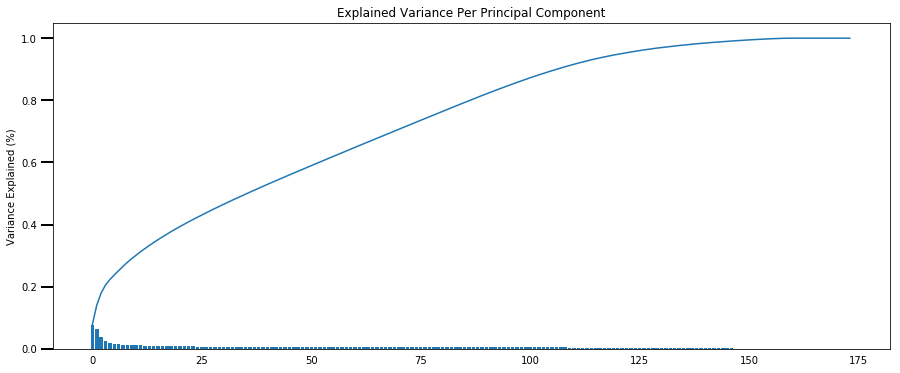

In [122]:
# Plotting explained variance per principal component
scree_plot(pca)


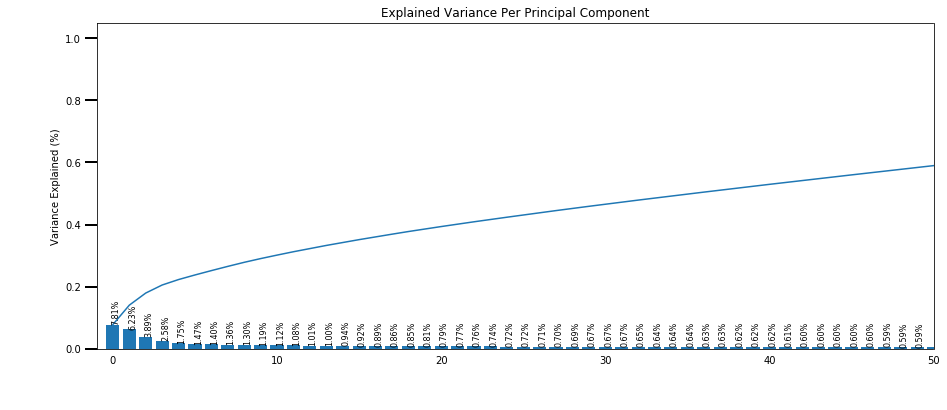

In [123]:
# Plotting explained variance for the first 50 principal component
scree_plot(pca, limit=50)


In [124]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca, X_pca = do_pca(azdias_scaled, 50)


In [125]:
# Components and features
pca.components_.shape

(50, 174)

### Discussion 2.2: Perform Dimensionality Reduction

I created a PCA function that I can reuse later on that instantiates the PCA and fits and transforms the data to it. I then created a scree plot that shows the sequential and cumulative explained variance per component. Looking at the cumulative explained variance, at around 50 components we're reaching 60% of explained variance, beyond that every component adds less than 0.6% of variance. Thus, I will keep 60 components and assume that this suffices to predict the customer segments.


### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [126]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def sort_weights(pca, columns, component):
    '''
    Prints an ordered dictionary with the weights and corresponding features per specified principal component
    INPUT: PCA, column/feature names, component index to be analyzed
    OUTPUT: ordered dictionary with weights as keys and feature names as values
    '''
    pca_weights = pd.DataFrame(pca.components_,columns=columns)
    sort_dict = defaultdict()
    counter = 0 
    for feat in pca_weights.loc[component]:
        sort_dict[feat] = pca_weights.loc[component].index[counter]
        counter+=1
        
    result = OrderedDict(sorted(sort_dict.items()))
    
    return result
    
sort_weights(pca, azdias_scaled.columns, 0)
    


OrderedDict([(-0.2108327732404591, 'MOBI_REGIO'),
             (-0.20699577585429246, 'FINANZ_MINIMALIST'),
             (-0.19383375198881742, 'KBA05_ANTG1'),
             (-0.1907713821855724, 'PLZ8_ANTG1'),
             (-0.18598983136643757, 'KBA05_GBZ'),
             (-0.14480808899004483, 'KONSUMNAEHE'),
             (-0.13941506936746864, 'PLZ8_GBZ'),
             (-0.13648426764746, 'INNENSTADT'),
             (-0.11598244254317605, 'LP_STATUS_FEIN_9'),
             (-0.11498411708503803, 'LIFE_STAGE'),
             (-0.11405577418128358, 'LP_STATUS_FEIN_8'),
             (-0.11224917965439019, 'ALTERSKATEGORIE_GROB'),
             (-0.1101213248118679, 'FINANZ_VORSORGER'),
             (-0.10548864349629238, 'GEBAEUDETYP_RASTER'),
             (-0.10487033817697229, 'BALLRAUM'),
             (-0.10257398106588062, 'MOVEMENT'),
             (-0.0957280259067114, 'GEBAEUDETYP_0'),
             (-0.0937088689432509, 'ZABEOTYP_0'),
             (-0.09214536364331574, 'FINANZTYP_1'

In [127]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
sort_weights(pca, azdias_scaled.columns, 1)


OrderedDict([(-0.2210568782688554, 'DECADE'),
             (-0.21352342012916464, 'FINANZ_SPARER'),
             (-0.20966158550937586, 'FINANZ_UNAUFFAELLIGER'),
             (-0.20748157326733788, 'SEMIO_REL'),
             (-0.20228304833996436, 'SEMIO_TRADV'),
             (-0.19809636741513367, 'FINANZ_ANLEGER'),
             (-0.19615987517882494, 'SEMIO_PFLICHT'),
             (-0.16533798883962778, 'ONLINE_AFFINITAET'),
             (-0.16329305079262016, 'SEMIO_KULT'),
             (-0.15929639982984264, 'SEMIO_RAT'),
             (-0.1314685195604506, 'SEMIO_FAM'),
             (-0.1265111928668872, 'SEMIO_MAT'),
             (-0.11786273133021058, 'FINANZTYP_0'),
             (-0.09943027435310663, 'ZABEOTYP_3'),
             (-0.09081232223013636, 'MOBI_REGIO'),
             (-0.08984675958085114, 'PLZ8_ANTG1'),
             (-0.08878468274976568, 'FINANZTYP_3'),
             (-0.08649028953145833, 'KBA05_GBZ'),
             (-0.08321867044911171, 'LP_STATUS_FEIN_4'),
      

In [128]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
sort_weights(pca, azdias_scaled.columns, 2)


OrderedDict([(-0.3494323703931889, 'ANREDE_KZ'),
             (-0.3207784107963657, 'SEMIO_KAEM'),
             (-0.2898844740212036, 'SEMIO_DOM'),
             (-0.2694834586074569, 'SEMIO_KRIT'),
             (-0.20609211007598938, 'SEMIO_ERL'),
             (-0.1616800771407703, 'SEMIO_RAT'),
             (-0.15660338779018648, 'FINANZ_ANLEGER'),
             (-0.10540168161602052, 'FINANZTYP_0'),
             (-0.09398840140160432, 'SHOPPER_TYP_2'),
             (-0.0848853274089614, 'LP_STATUS_FEIN_1'),
             (-0.06492777965130303, 'LP_STATUS_FEIN_3'),
             (-0.06442962089713386, 'ZABEOTYP_3'),
             (-0.06219262387374438, 'FINANZ_SPARER'),
             (-0.06176522944526642, 'DECADE'),
             (-0.059902006608108654, 'FINANZ_HAUSBAUER'),
             (-0.053395120036210365, 'FINANZ_UNAUFFAELLIGER'),
             (-0.052047010747916, 'SHOPPER_TYP_3'),
             (-0.05035456508007795, 'INNENSTADT'),
             (-0.04463467945030937, 'BALLRAUM'),
    

### Discussion 2.3: Interpret Principal Components

Based on the weights of the features within the first three principal components, the following things can be deduced:
* the four features SEMIO_KULT, SEMIO_SOZ, SEMIO_FAM and SEMIO_VERT are closely correlated (cf. the third PC) and will increase together
* the five features SEMIO_KAEM, SEMIO_DOM, SEMIO_KRIT, SEMIO_ERL, SEMIO_RAT are closely correlated as well (cf. the third PC), however, their weights are negative so this means that these five features will decrease if the previous four features will increase
* in the third principle component, ANREDE_KZ (which refers to gender) has the highest negativ weight and thus, a big influence on this component
* in general, the above features have a strong influence on the overall third PCA component
* in the second principal component, there is a strong influence of DECADE (so the decade of major youth influence) and financial typology (e.g. FINANZ_UNAUFFAELLIGER) as well as personality typology (SEMIO_PFLICHT) are correlated with each other and have a high influence on the component
* the above components are negatively correlated with ALTERSKATEGORIE_GROB (which is also the feature with the highest positive weight in the component), ZABEOTYP_2 and FINANZ_VORSORGER, to name a few
* the first principle component has FINANZ_MINIMALIST as the lowest (negative) weight and PLZ8_ANTG3 as the highest (positive) weight, hence, these two features are negatively correlated



## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [129]:
# Over a number of different cluster counts...
all_kmeans = []
num_clust = 15
for i in range(1,num_clust):
    # run k-means clustering on the data and...
    kmeans_i = KMeans(n_clusters=i, random_state=42)
    # compute the average within-cluster distances.
    print(kmeans_i)
    model_i = kmeans_i.fit(X_pca).score(X_pca)
    all_kmeans.append(model_i)
    

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=1, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_

In [130]:
# saving the calculated clusters
stored_kmeans_50pca = [-79972279.8238419, -71820797.588833332, -67346531.293712184, -64618440.739884786, -62921518.728281647, -61484008.23849187, -60208325.176914841, -59149625.831960775, -58384575.107355811, -57595118.177211426, -57094479.286420479, -56330145.494117014, -55886759.715527982, -55423370.074466452]
print(all_kmeans)


[-79972279.8238419, -71820797.588833332, -67346531.293712184, -64618440.739884786, -62921518.728281647, -61484008.23849187, -60208325.176914841, -59149625.831960775, -58384575.107355811, -57595118.177211426, -57094479.286420479, -56330145.494117014, -55886759.715527982, -55423370.074466452]


In [131]:
# prepare data to be plotted
num_clust = [x for x in range(1,15)]
all_kmeans_new = [-x for x in stored_kmeans_50pca]

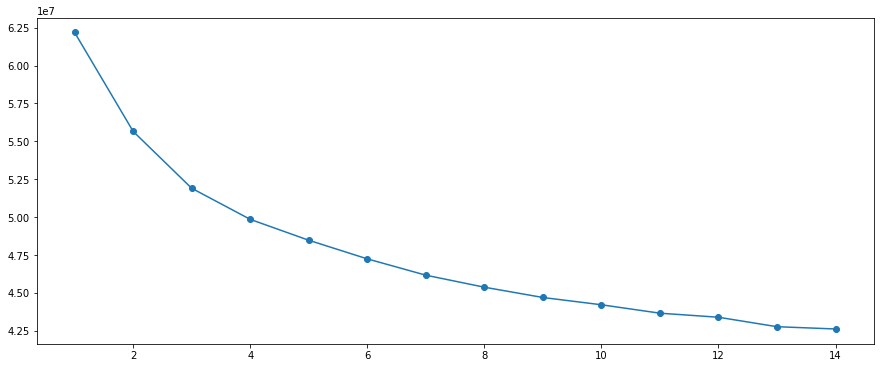

In [132]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.figure(figsize=(15,6))
plt.plot(num_clust, all_kmeans_new, marker='o')


In [133]:
# Refitting the data into clusters
def cluster_fitting(num_clust, data):
    kmeans_i = KMeans(n_clusters=num_clust)
    model_i = kmeans_i.fit(data)
    predict_pop_i = model_i.predict(data)
    
    return model_i, predict_pop_i


In [134]:
model_11, predict_pop_11 = cluster_fitting(11, X_pca)

In [135]:
pop_pred = pd.DataFrame(np.array(predict_pop_11), columns=['Prediction'])

grouped_pop = pop_pred.groupby('Prediction').size()

In [136]:
grouped_pop

Prediction
0      53541
1      97223
2      82567
3      64677
4     104223
5      54547
6      88530
7      56935
8      78226
9      79505
10     37104
dtype: int64

### Discussion 3.1: Apply Clustering to General Population

Based on the above visualization, I would cluster the dataset into 11 clusters because after this point, the slope decreases less than before. Thus, I would determine that 11 is the 'elbow' of this visualization which is why I am choosing it as the optimal number of clusters.


### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [178]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')
customers.shape


(191652, 85)

In [179]:
# Apply preprocessing and feature transformation from the general demographics onto the customer data
cleaned_df, df_missing = clean_data(customers)


/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


All done


In [180]:
print(cleaned_df.shape)
print(cleaned_df.isnull().sum().sum())


(141590, 173)
96023


In [181]:
# Apply imputation to the customer data
impute_num = pd.DataFrame(imp_num.transform(cleaned_df[all_var]), columns=cleaned_df[all_var].columns)
cleaned_df.drop(all_var, axis=1, inplace=True)
cust_impute = pd.concat([cleaned_df, impute_num], axis=1)
cust_impute.head()


,ANREDE_KZ,GREEN_AVANTGARDE,SOHO_KZ,CJT_GESAMTTYP_0,CJT_GESAMTTYP_1,CJT_GESAMTTYP_2,CJT_GESAMTTYP_3,CJT_GESAMTTYP_4,CJT_GESAMTTYP_5,FINANZTYP_0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,GFK_URLAUBERTYP_0,GFK_URLAUBERTYP_1,GFK_URLAUBERTYP_2,GFK_URLAUBERTYP_3,GFK_URLAUBERTYP_4,GFK_URLAUBERTYP_5,GFK_URLAUBERTYP_6,GFK_URLAUBERTYP_7,GFK_URLAUBERTYP_8,GFK_URLAUBERTYP_9,GFK_URLAUBERTYP_10,GFK_URLAUBERTYP_11,LP_FAMILIE_FEIN_0,LP_FAMILIE_FEIN_1,LP_FAMILIE_FEIN_2,LP_FAMILIE_FEIN_3,LP_FAMILIE_FEIN_4,LP_FAMILIE_FEIN_5,LP_FAMILIE_FEIN_6,LP_FAMILIE_FEIN_7,LP_FAMILIE_FEIN_8,LP_FAMILIE_FEIN_9,LP_FAMILIE_FEIN_10,LP_STATUS_FEIN_0,LP_STATUS_FEIN_1,LP_STATUS_FEIN_2,LP_STATUS_FEIN_3,LP_STATUS_FEIN_4,LP_STATUS_FEIN_5,LP_STATUS_FEIN_6,LP_STATUS_FEIN_7,LP_STATUS_FEIN_8,LP_STATUS_FEIN_9,NATIONALITAET_KZ_0,NATIONALITAET_KZ_1,NATIONALITAET_KZ_2,SHOPPER_TYP_0,SHOPPER_TYP_1,SHOPPER_TYP_2,SHOPPER_TYP_3,VERS_TYP_0,VERS_TYP_1,ZABEOTYP_0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,GEBAEUDETYP_0,GEBAEUDETYP_1,GEBAEUDETYP_2,GEBAEUDETYP_3,GEBAEUDETYP_4,GEBAEUDETYP_5,CAMEO_DEU_2015_0,CAMEO_DEU_2015_1,CAMEO_DEU_2015_2,CAMEO_DEU_2015_3,CAMEO_DEU_2015_4,CAMEO_DEU_2015_5,CAMEO_DEU_2015_6,CAMEO_DEU_2015_7,CAMEO_DEU_2015_8,CAMEO_DEU_2015_9,CAMEO_DEU_2015_10,CAMEO_DEU_2015_11,CAMEO_DEU_2015_12,CAMEO_DEU_2015_13,CAMEO_DEU_2015_14,CAMEO_DEU_2015_15,CAMEO_DEU_2015_16,CAMEO_DEU_2015_17,CAMEO_DEU_2015_18,CAMEO_DEU_2015_19,CAMEO_DEU_2015_20,CAMEO_DEU_2015_21,CAMEO_DEU_2015_22,CAMEO_DEU_2015_23,CAMEO_DEU_2015_24,CAMEO_DEU_2015_25,CAMEO_DEU_2015_26,CAMEO_DEU_2015_27,CAMEO_DEU_2015_28,CAMEO_DEU_2015_29,CAMEO_DEU_2015_30,CAMEO_DEU_2015_31,CAMEO_DEU_2015_32,CAMEO_DEU_2015_33,CAMEO_DEU_2015_34,CAMEO_DEU_2015_35,CAMEO_DEU_2015_36,CAMEO_DEU_2015_37,CAMEO_DEU_2015_38,CAMEO_DEU_2015_39,CAMEO_DEU_2015_40,CAMEO_DEU_2015_41,CAMEO_DEU_2015_42,CAMEO_DEU_2015_43,MOVEMENT,DECADE,WEALTH,LIFE_STAGE,BUSINESS_BUILDING,ANZ_PERSONEN,ANZ_TITEL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,MIN_GEBAEUDEJAHR,KBA13_ANZAHL_PKW,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,KONSUMNAEHE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,1,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,50,1,3,0,2.0,0.0,1.0,0.0,1992.0,1201.0,4.0,5.0,1.0,5.0,1.0,2.0,2.0,1.0,5.0,6.0,5.0,2.0,6.0,6.0,7.0,3.0,4.0,1.0,3.0,1.0,1.0,2.0,1.0,1.0,6.0,9.0,5.0,2.0,2.0,0.0,0.0,4.0,3.0,2.0,4.0,4.0,1.0,4.0,3.0,1.0,3.0,3.0,1.0,0.0,5.0,5.0,1.0,2.0,1.0
1,2,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,50,3,4,0,1.0,0.0,1.0,0.0,1992.0,433.0,4.0,5.0,1.0,5.0,1.0,4.0,4.0,2.0,5.0,2.0,2.0,1.0,3.0,3.0,7.0,7.0,1.0,2.0,7.0,5.0,6.0,4.0,1.0,1.0,6.0,9.0,1.0,2.0,2.0,0.0,0.0,3.0,7.0,4.0,1.0,3.0,3.0,3.0,1.0,7.0,2.0,3.0,3.0,1.0,3.0,2.0,3.0,5.0,3.0
2,1,0,0.0,0.0,1.0,0.0,0.0,0

There is a variable missing, most likely this stems from the customer data having a categorical variable that does not have a certain return and therefore, this particular return was not stored as a variable after onehotencoding. I will extract this variable and add it as a dummy variable to the customer dataset.

In [182]:
# Identify missing value and add it as a dummy variable to the customer dataset
missing_var_cust = [x for x in azdias_scaled.columns if x not in cust_impute.columns] 

print(missing_var_cust)

index = azdias_scaled.columns.get_loc(missing_var_cust[0])
print(index)

cust_impute.insert(loc=index, column=missing_var_cust[0], value=0)

print(cust_impute.shape)


['GEBAEUDETYP_6']
69
(141590, 174)


In [183]:
# Apply feature scaling to the customer data.
scaled_cust = scaler.transform(cust_impute.iloc[:,:120])
scaled_cust1 = scaler1.transform(cust_impute.iloc[:,120:])

cust_scaled1 = pd.DataFrame(scaled_cust, columns=cust_impute.columns[:120])
cust_scaled2 = pd.DataFrame(scaled_cust1, columns=cust_impute.columns[120:])

cust_scaled = pd.concat([cust_scaled1, cust_scaled2], axis=1)


In [186]:
cust_scaled.describe()

,ANREDE_KZ,GREEN_AVANTGARDE,SOHO_KZ,CJT_GESAMTTYP_0,CJT_GESAMTTYP_1,CJT_GESAMTTYP_2,CJT_GESAMTTYP_3,CJT_GESAMTTYP_4,CJT_GESAMTTYP_5,FINANZTYP_0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,GFK_URLAUBERTYP_0,GFK_URLAUBERTYP_1,GFK_URLAUBERTYP_2,GFK_URLAUBERTYP_3,GFK_URLAUBERTYP_4,GFK_URLAUBERTYP_5,GFK_URLAUBERTYP_6,GFK_URLAUBERTYP_7,GFK_URLAUBERTYP_8,GFK_URLAUBERTYP_9,GFK_URLAUBERTYP_10,GFK_URLAUBERTYP_11,LP_FAMILIE_FEIN_0,LP_FAMILIE_FEIN_1,LP_FAMILIE_FEIN_2,LP_FAMILIE_FEIN_3,LP_FAMILIE_FEIN_4,LP_FAMILIE_FEIN_5,LP_FAMILIE_FEIN_6,LP_FAMILIE_FEIN_7,LP_FAMILIE_FEIN_8,LP_FAMILIE_FEIN_9,LP_FAMILIE_FEIN_10,LP_STATUS_FEIN_0,LP_STATUS_FEIN_1,LP_STATUS_FEIN_2,LP_STATUS_FEIN_3,LP_STATUS_FEIN_4,LP_STATUS_FEIN_5,LP_STATUS_FEIN_6,LP_STATUS_FEIN_7,LP_STATUS_FEIN_8,LP_STATUS_FEIN_9,NATIONALITAET_KZ_0,NATIONALITAET_KZ_1,NATIONALITAET_KZ_2,SHOPPER_TYP_0,SHOPPER_TYP_1,SHOPPER_TYP_2,SHOPPER_TYP_3,VERS_TYP_0,VERS_TYP_1,ZABEOTYP_0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,GEBAEUDETYP_0,GEBAEUDETYP_1,GEBAEUDETYP_2,GEBAEUDETYP_3,GEBAEUDETYP_4,GEBAEUDETYP_5,GEBAEUDETYP_6,CAMEO_DEU_2015_0,CAMEO_DEU_2015_1,CAMEO_DEU_2015_2,CAMEO_DEU_2015_3,CAMEO_DEU_2015_4,CAMEO_DEU_2015_5,CAMEO_DEU_2015_6,CAMEO_DEU_2015_7,CAMEO_DEU_2015_8,CAMEO_DEU_2015_9,CAMEO_DEU_2015_10,CAMEO_DEU_2015_11,CAMEO_DEU_2015_12,CAMEO_DEU_2015_13,CAMEO_DEU_2015_14,CAMEO_DEU_2015_15,CAMEO_DEU_2015_16,CAMEO_DEU_2015_17,CAMEO_DEU_2015_18,CAMEO_DEU_2015_19,CAMEO_DEU_2015_20,CAMEO_DEU_2015_21,CAMEO_DEU_2015_22,CAMEO_DEU_2015_23,CAMEO_DEU_2015_24,CAMEO_DEU_2015_25,CAMEO_DEU_2015_26,CAMEO_DEU_2015_27,CAMEO_DEU_2015_28,CAMEO_DEU_2015_29,CAMEO_DEU_2015_30,CAMEO_DEU_2015_31,CAMEO_DEU_2015_32,CAMEO_DEU_2015_33,CAMEO_DEU_2015_34,CAMEO_DEU_2015_35,CAMEO_DEU_2015_36,CAMEO_DEU_2015_37,CAMEO_DEU_2015_38,CAMEO_DEU_2015_39,CAMEO_DEU_2015_40,CAMEO_DEU_2015_41,CAMEO_DEU_2015_42,CAMEO_DEU_2015_43,MOVEMENT,DECADE,WEALTH,LIFE_STAGE,BUSINESS_BUILDING,ANZ_PERSONEN,ANZ_TITEL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,MIN_GEBAEUDEJAHR,KBA13_ANZAHL_PKW,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,KONSUMNAEHE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,1.415900e+05,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.00

In [187]:
# Apply PCA to the data while selecting for number of components to retain.
cust_pca = pca.transform(cust_scaled)


In [188]:
# Fitting the customer data into 11 clusters
model_11_cust = model_11.predict(cust_pca)

model_11_cust

array([7, 5, 2, ..., 7, 9, 2], dtype=int32)

In [189]:
cust_pred = pd.DataFrame(np.array(model_11.predict(cust_pca)), columns=['Prediction'])

grouped_cust = cust_pred.groupby('Prediction').size()

grouped_cust

Prediction
0      1878
1     13721
2     26309
3      1105
4     15250
5     16615
6      1357
7     47415
8      1706
9     12047
10     4187
dtype: int64

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [190]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
def cluster_prop(cluster_pop, cluster_cust):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    sb.countplot(cluster_pop, color=sb.color_palette()[1])
    plt.xlabel('General population clusters')
    plt.ylabel('Number of occurences')
    plt.title('General population')

    plt.subplot(1, 2, 2)
    sb.countplot(cluster_cust, color=sb.color_palette()[2])
    plt.xlabel('Customer clusters')
    plt.ylabel('Number of occurences')
    plt.title('Customers')
    
    #plt.subplot(1, 3, 3)
    #sb.countplot(cluster_pop_mis, color=sb.color_palette()[0])
    #plt.xlabel('General population missing data clusters')
    #plt.ylabel('Number of occurences')
    #plt.title('General population missing data')


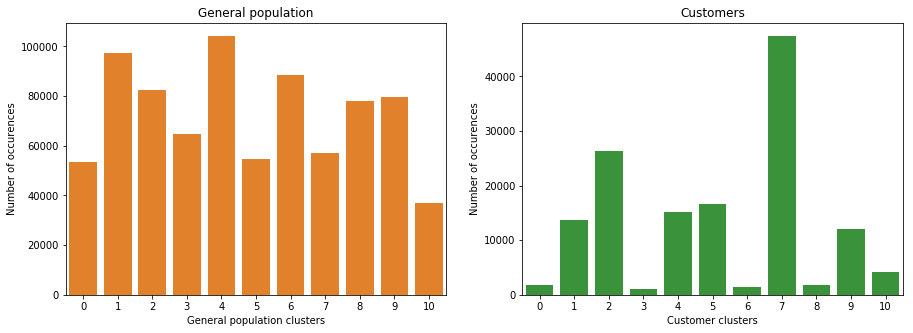

In [191]:
cluster_prop(predict_pop_11, model_11_cust)

In [ ]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?



In [ ]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?



### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.